# Description

This notebook makes use of the **pandas** library and the **ete3 toolkit**, specifically ete3's [NCBI Taxonomic database](http://etetoolkit.org/docs/latest/tutorial/tutorial_ncbitaxonomy.html). Several custom functions simplifying the use of ete3 are in the zoonosis_helper_functions.py script which is imported into the notebook.


The primary data is obtained from the Uniprot database. It contains data on proteins which facilitate viral [entry into host cells](https://www.uniprot.org/uniprot/?query=keyword:%22Virus%20entry%20into%20host%20cell%20[KW-1160]%22). The data is in 2 parts, the first being the [tabular data](#tabular-data) and the second being the [fasta sequences](#fasta) of the virus surface proteins. The 2 are linked by their uniprot entry identifiers. A very small portion of the data has been reviewed and is not sufficient for application in deep learning so both the reviewed and unreviewed data is kept, however, the unreviewed data lacks information on host data.

To alleviate the host data information, external sources were used, namely:

- [NCBI Virus database](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?VirusLineage_ss=Viruses,%20taxid:10239&SeqType_s=Protein&Proviral_s=exclude&HostLineage_ss=Mammalia%20(mammals),%20taxid:40674)
- [Virus-Host database](https://www.genome.jp/virushostdb/)
- [Enhanced Infectious Disease Database (EID2)](https://eid2.liverpool.ac.uk/OrganismInteractions)

1. [The ete3 is first used to obtain taxomomic identifiers at the species level and if an identifier is already present to still use the ete3 taxonomic identifiers for consistency.](#ete3-taxo)

1. [Data is further filtered to keep only viruses (organism).](#filter)

1. [The dataset contains some repetitive information i.e. same virus, same hosts but different protein or different protein entry. Therefore, the next step was to fill in the host data using information from the reviewed data. The premise was if it's the same virus then it ought to have the same hosts.](#Updating-host-names-from-other-host-data-in-the-dataset)

1. [Thereafter information form external sources is appended to the primary data. Missing data after final processing is dropped.](#Updating-host-names-from-external-sources)

1. [An additional column (Infects human) is then later added. If at least one of the virus hosts is homo sapiens then an assignment of **1** is given otherwise **0** is assigned to the row.](#Further-Processing)

1. [Since the data was obtained from multiple sources further processing was done to make the information format consistent.](#host-name-consistency)

1. [The sequence data is loaded and linked to the tabular data.](#fasta)

1. [Protein names are also updated from sequence data for consistency in the data.](#protein-names-from-sequence)

1. [After processing, the data is then split into training and testing data. Validation split is done upon loading the training data with **keras**.](#splits)

1. [random undersampling](#Random-Undersampling-of-datasets)

1. [Write file sequences to fasta for feature extraction](#Write-file-sequences-to-fasta-for-feature-extraction)


<!-- ### [Absolutely no idea why Virus host name != Virus hosts](#issue) -->

## Packages

In [1]:
# Import all necesssary modules
## Always import pandas before swifter ##
import pandas as pd
import swifter # enables pandas multiprocessing using modin and ray as a backend. Also adds progress bar functionality
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import re
import os
from ete3 import NCBITaxa # Takes a while on first time load
from pprint import pprint
from tqdm.notebook import tqdm_notebook, tqdm
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)
import sys
sys.path.insert(1, "/users/rserage/Zoon0PredV/bin/")
from zoonosis_helper_functions import * # in the current directory

In [2]:
# Configure Progress bar and Modin Pandas Engine

tqdm.pandas(desc='Processing')
os.environ["MODIN_ENGINE"] = "ray"

## Data exploration

<a id='tabular-data'></a>

In [3]:
# Load dataset downloaded from Uniprot
df = pd.read_table('../data/uniprot-keyword Virus+entry+into+host+cell+[KW-1160] +fragment no.tab.gz')

In [4]:
df.shape

(358333, 9)

In [5]:
df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
226493,A0A4Y5N1L5,A0A4Y5N1L5_SFV,unreviewed,Togavirin (EC 3.4.21.90),Semliki forest virus (SFV),1253,11033,Semliki forest virus (SFV),Aedes [TaxID: 7158]; Atelerix albiventris (Mid...
225916,A0A2P1I8C9,A0A2P1I8C9_HPV16,unreviewed,Minor capsid protein L2,Human papillomavirus type 16,473,333760,Alphapapillomavirus 9,Homo sapiens (Human) [TaxID: 9606]
64715,I1V4V5,I1V4V5_HRSV,unreviewed,Major surface glycoprotein G (Attachment glyco...,Human respiratory syncytial virus,310,11250,Human respiratory syncytial virus,Homo sapiens (Human) [TaxID: 9606]


In [6]:
title_params = {'fontsize': 17,
                'fontweight': 'bold'}

[Matplotlib font stuff](https://matplotlib.org/stable/tutorials/text/text_props.html)

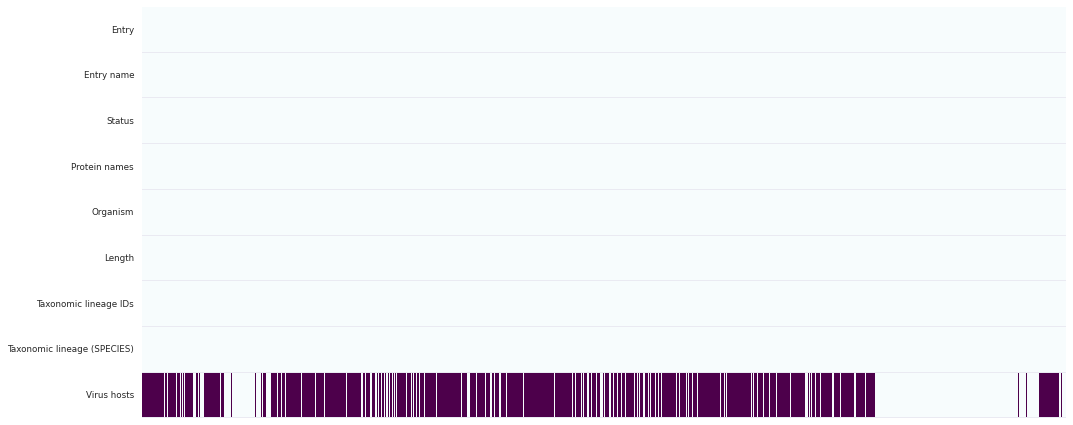

In [7]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df.copy().T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

# ax.set_title("Missing values in the KW-1161 dataset", fontdict=title_params)

plt.tight_layout()
# plt.savefig("Missing_hosts_heatmap.png")

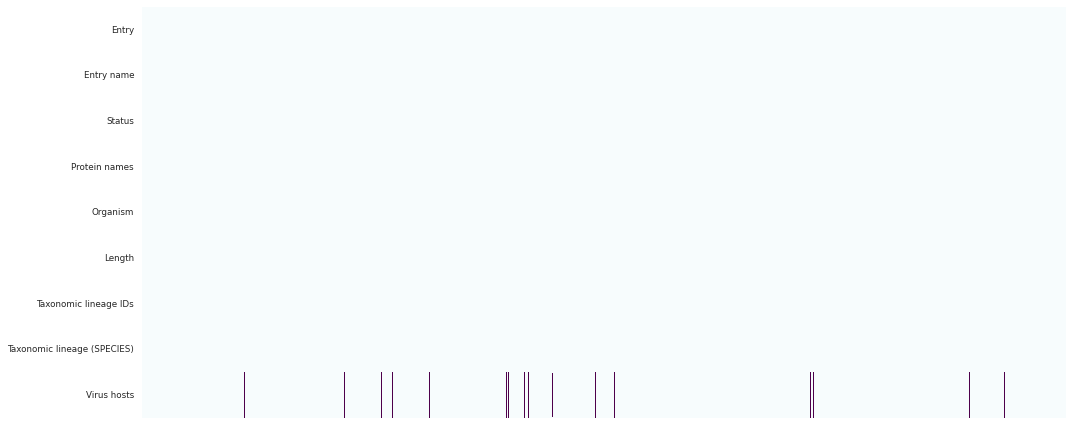

In [8]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df[df["Status"] == "reviewed"].T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

# ax.set_title("Missing values in the KW-1161 dataset reviewed by UniProt", fontdict=title_params)

plt.tight_layout()
# plt.savefig("Reviewed_missing_hosts_heatmap.png")

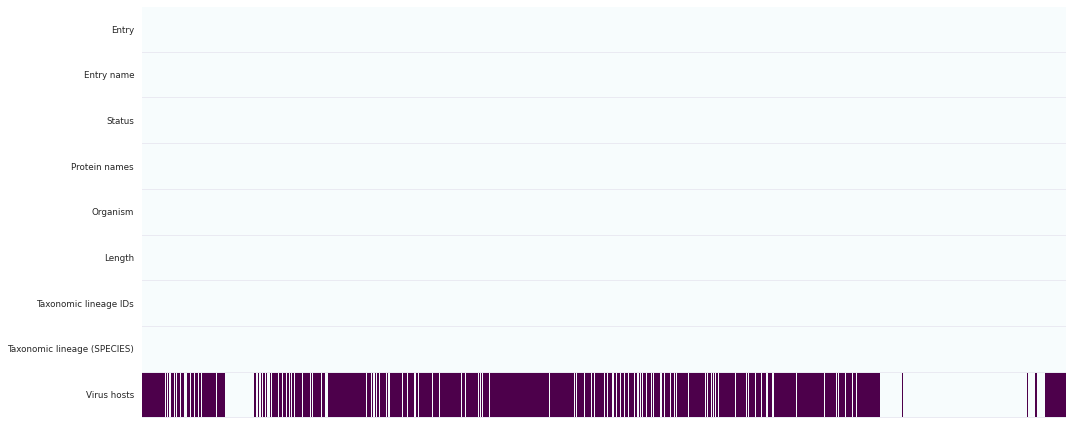

In [9]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df[df["Status"] == "unreviewed"].T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

# ax.set_title("Missing values in the KW-1161 dataset not reviewed by UniProt", fontdict=title_params)

plt.tight_layout()
# plt.savefig("Unreviewed_missing_hosts_heatmap.png")

In [10]:
# Check for number of rows with missing host names
print(df[df['Virus hosts'].isnull()].shape)
df[df['Virus hosts'].isnull()].sample(3)

(237573, 9)


,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
355366,A0A1Q3WK18,A0A1Q3WK18_9PROT,unreviewed,Integrase,Thiobacillus sp. 65-1402,402,1895861,Thiobacillus sp. 65-1402,NaN
236291,A0A2D1CS19,A0A2D1CS19_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/swine/Minnesota/A01785291...,565,2042047,Influenza A virus,NaN
2681,A0A0A0F508,A0A0A0F508_ECOLX,unreviewed,DUF4102 domain-containing protein (Integrase a...,Escherichia coli,420,562,Escherichia coli,NaN


In [11]:
# Total number of different organisms in dataset (inclusive of reviewed and non-reviewed)
df['Organism'].nunique()

100216

In [12]:
# Total number of different organisms with reviewed data
df[df['Status'] == 'reviewed']['Organism'].nunique()

1518

In [13]:
df[df['Status'] == 'unreviewed']['Organism'].nunique()

99095

In [14]:
# Check for number of rows with reviewed hosts
df[df['Status'] == 'reviewed']['Virus hosts'].nunique()

321

In [15]:
df[df['Status'] == 'unreviewed']['Virus hosts'].nunique()

200

In [16]:
# Total number of rows with host information (inclusive of reviewed and non-reviewed)
df['Virus hosts'].nunique()

373

In [17]:
# Checking if there is no missing organism taxonomy data. Organism == Tax IDs
df['Taxonomic lineage IDs'].nunique()

100216

In [18]:
def variable_value_heatmap(df, variable: str):
    overview = df.copy().melt(id_vars=['Entry'], value_vars=[variable])
    crosstab_overview = pd.crosstab(overview['variable'], overview['value'])
    ax = sns.barplot(data=df)
    return crosstab_overview.head()

value,reviewed,unreviewed
variable,,
Status,2426,355907


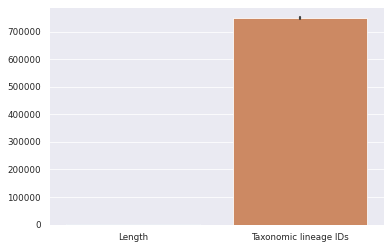

In [19]:
variable_value_heatmap(df, "Status")

In [20]:
overview = df.copy().melt(id_vars=['Entry'], value_vars=["Status"])
crosstab_overview = pd.crosstab(overview['variable'], overview['value'])

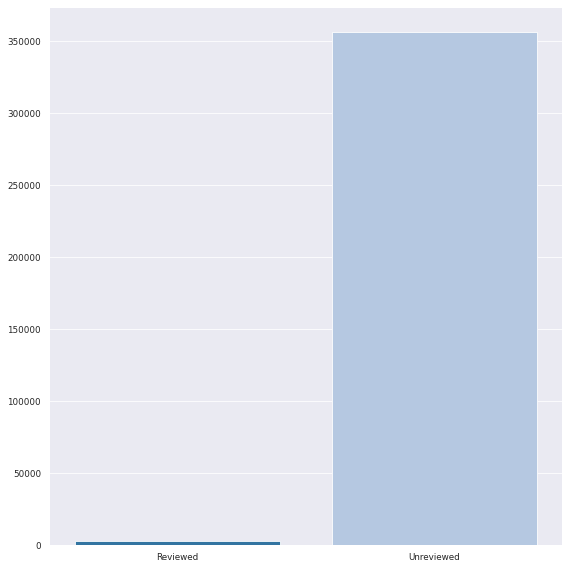

In [21]:
plt.figure(figsize=(8,8))
sns.set_theme(context="paper", style="darkgrid", palette="tab20")

ax = sns.barplot(data=crosstab_overview)

# ax.set_title("Reviewed vs Unreviewed data entries in the\nKW-1161 dataset", fontdict=title_params)

ax.set_xticklabels(["Reviewed", "Unreviewed"])
ax.set_xlabel("")
ax.set_yscale("log")

plt.tight_layout()
# plt.savefig("Reviewed_unreviewed_barplot.png")

In [22]:
label_text_params = {'fontsize': 'x-small'}

In [23]:
# overview = pd.pivot_table(df, values=["Protein names", "Virus hosts"],
#                           index="Taxonomic lineage (SPECIES)", fill_value="",
#                           # columns=,
#                           aggfunc={"Protein names":lambda x: len(set(x)), "Virus hosts":lambda x: len(set(x))})

# overview.sample(10)

# plt.figure(figsize=(15,40))

# ax = sns.heatmap(overview, cmap="Blues", vmin=0, vmax=5,
#             # cbar=False, annot=True,
#             # xticklabels=False, yticklabels=False,
#                 )
# ax.set_title("Overview of number of proteins and host groups per virus species", fontdict=title_params)
# ax.set_ylabel('')
# ax.set_xticklabels(['Proteins', 'Hosts'])
# ax.set_yticklabels(ax.get_yticklabels(), fontdict=label_text_params)

# plt.tight_layout()
# plt.savefig("Species_prot_host.png")

In [24]:
df['Length'] = df['Length'].apply(int)

In [25]:
data_sample = df.sample(8000)

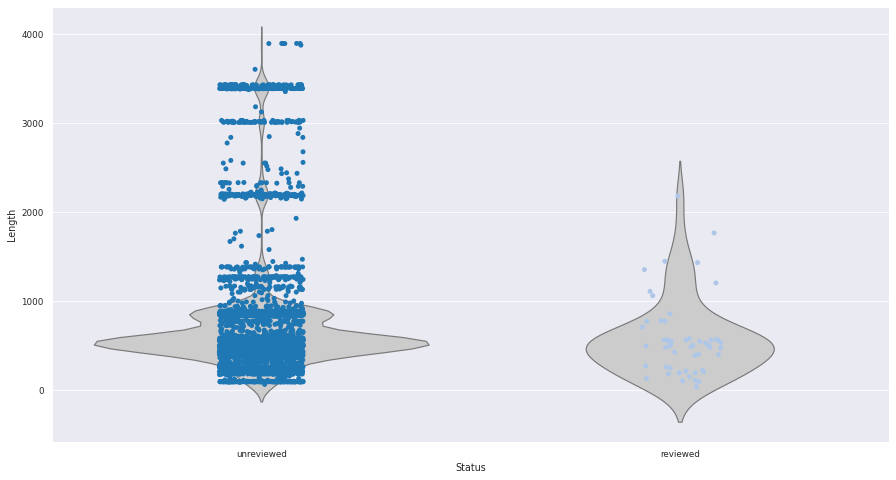

In [26]:
plt.figure(figsize=(15, 8))
sns.set_theme(context="paper", style="darkgrid", palette="tab20")


ax = sns.violinplot(x="Status", y="Length", data=data_sample,
                    inner=None, color=".8")

ax = sns.stripplot(x="Status", y="Length", data=data_sample)

In [27]:
# plt.figure(figsize=(16, 8))
# sns.set_theme(style="darkgrid")

# ax = sns.swarmplot(x="Status", y="Length", data=data_sample)

# ax.set_title("Distribution of protein sequence lengths sample", fontdict=title_params)
# ax.set_ylabel('Protein sequence length')
# ax.set_xticklabels(['Unreviewed', 'Reviewed'])
# # ax.set_yticklabels(ax.get_yticklabels(), fontdict=label_text_params)

# plt.tight_layout()

# # plt.savefig("Dist_protein_length.png")

## Initial processing

In [28]:
df_full_record_tracking = dict()
df_full_record_tracking.update({"Preprocessed": df.shape[0]})

In [29]:
## Replace N/A columns with an empty string... prevents errors with column wide string operations
df['Virus hosts'] = np.where(df['Virus hosts'].isnull(), '', df['Virus hosts'])

In [30]:
df.sample(5)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
10430,A0A4D6TXC5,A0A4D6TXC5_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus,566,11320,Influenza A virus,
227849,Q2HWY8,Q2HWY8_CHV16,unreviewed,Envelope glycoprotein B (gB),Cercopithecine herpesvirus 16 (CeHV-16) (Herpe...,894,340907,Cercopithecine herpesvirus 16 (CeHV-16) (Herpe...,Homo sapiens (Human) [TaxID: 9606]; Macaca fas...
170186,A0A023LXR8,A0A023LXR8_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus (A/mallard/Wisconsin/1071/19...,498,1406530,Influenza A virus,
273515,X2EN81,X2EN81_9INFA,unreviewed,Nucleoprotein (Nucleocapsid protein) (Protein N),Influenza A virus (A/Chicago/YGA_04001/2012(H3...,498,1427759,Influenza A virus,
223988,U5XI28,U5XI28_9INFA,unreviewed,Hemagglutinin [Cleaved into: Hemagglutinin HA1...,Influenza A virus (A/Kansas/04/2013(H3N2)),566,1416134,Influenza A virus,


In [31]:
def join_names(df, col_name: str):
    df[col_name] = df[col_name].str.split('; ').apply(set).apply('; '.join) # 'set' function removes duplicate entries
    return df

In [32]:
# df['Virus hosts'] = df['Virus hosts'].str.split('; ')
# df['Virus hosts'] = df['Virus hosts'].swifter.progress_bar(enable=True, desc='Removing duplicate host names').apply(set)
# df['Virus hosts'] = df['Virus hosts'].swifter.progress_bar(enable=True, desc='Joining host names list').apply('; '.join)

# df['Protein names'] = df['Protein names'].str.split('; ')
# df['Protein names'] = df['Protein names'].swifter.progress_bar(enable=True, desc='Removing duplicate protein names').apply(set)
# df['Protein names'] = df['Protein names'].swifter.progress_bar(enable=True, desc='Joining protein names list').apply('; '.join)

# df['Organism'] = df['Organism'].str.split('; ')
# df['Organism'] = df['Organism'].swifter.progress_bar(enable=True, desc='Removing duplicate organism names').apply(set)
# df['Organism'] = df['Organism'].swifter.progress_bar(enable=True, desc='Joining organism names list').apply('; '.join)

In [33]:
# Remove duplicate entries if present
df = join_names(df, 'Virus hosts')
df = join_names(df, 'Protein names')
df = join_names(df, 'Organism')

df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts
153952,A0A2M9G0J2,A0A2M9G0J2_9PROT,unreviewed,Integrase,Minwuia thermotolerans,325,2056226,Minwuia thermotolerans,
102462,C1KKI1,C1KKI1_9FLAV,unreviewed,Core protein (EC 3.4.21.91) (EC 3.6.1.15) (EC ...,Dengue virus 2,3391,11060,Dengue virus,
195605,A0A0A7X6G2,A0A0A7X6G2_9INFA,unreviewed,Hemagglutinin HA2 chain]; Hemagglutinin [Cleav...,Influenza A virus (A/duck/Egypt/1471SG/2014(H5...,567,1577819,Influenza A virus,


<a id="ete3-taxo" ></a>

In [34]:
# Species ID from organism ID
df['Species taxonomic ID'] = (df['Taxonomic lineage IDs']
                              .swifter.progress_bar(enable=True, desc='Getting Viruses taxonomic IDs')
                              .apply(getRankID, rank='species')) # getRankID function in zoonosis_helper_functions.py

Getting Viruses taxonomic IDs:   0%|          | 0/64 [00:00<?, ?it/s]

In [35]:
# Copy for later use
dff = df[['Entry', 'Species taxonomic ID', 'Length']].copy()

In [36]:
df.sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID
220634,A0A140EV69,A0A140EV69_9INFB,unreviewed,Hemagglutinin HA2 chain]; Hemagglutinin [Cleav...,Influenza B virus (B/Waikato/41/2013),584,1757503,Influenza B virus,,11520.0
318666,B3VST9,B3VST9_9HIV1,unreviewed,Transmembrane protein gp41 (TM) (Glycoprotein ...,Human immunodeficiency virus 1,867,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606],11676.0
325526,A0A0U1ZB10,A0A0U1ZB10_9HIV1,unreviewed,Transmembrane protein gp41 (TM) (Glycoprotein ...,Human immunodeficiency virus 1,854,11676,Human immunodeficiency virus 1,Homo sapiens (Human) [TaxID: 9606],11676.0


In [37]:
# Check if all tax IDs could be found in NCBI taxonomy database
df[df['Species taxonomic ID'].isnull()].sample(3)

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID
276797,D9YV26,D9YV26_OSCV1,unreviewed,Genome polyprotein (EC 3.6.1.15) (P1C) (P1D) (...,Oscivirus A1 (isolate Oriental magpie robin/Ho...,2255,1554480,Oscivirus A,Copsychus saularis (Oriental magpie-robin) [Ta...,NaN
173440,D9YV24,D9YV24_PASVA,unreviewed,Genome polyprotein (P1C) (P1D) (Protein 2C) (P...,Passerivirus A1 (isolate Turdus pallidus/Hong ...,2428,1554479,Passerivirus A,Turdus pallidus (Pale thrush) [TaxID: 36282],NaN
195746,Q0NCP4,Q0NCP4_VAR65,unreviewed,Protein L5,Variola virus (isolate Human/South Africa/102/...,128,587201,Variola virus,Homo sapiens (Human) [TaxID: 9606],NaN


In [38]:
# Get the species name of the earlier unidentified taxonomic IDs
idx_species_name = df.columns.get_loc('Taxonomic lineage (SPECIES)')
idx_organism_id = df.columns.get_loc('Species taxonomic ID')

for row in tqdm_notebook(range(len(df)), desc='Getting species ID from organism name'):
    if np.isnan(df.iat[row, idx_organism_id]):
        # getIDfromName function in zoonosis_helper_functions.py
        df.iat[row, idx_organism_id] = getIDfromName(df.iat[row, idx_species_name])

Getting species ID from organism name:   0%|          | 0/358333 [00:00<?, ?it/s]

In [39]:
df[df['Species taxonomic ID'].isnull()]

,Entry,Entry name,Status,Protein names,Organism,Length,Taxonomic lineage IDs,Taxonomic lineage (SPECIES),Virus hosts,Species taxonomic ID


In [40]:
df['Species taxonomic ID'] = df['Species taxonomic ID'].apply(int) # convert taxid from floats to int

In [41]:
df.shape

(358333, 10)

In [42]:
df = (df.drop(['Status','Taxonomic lineage IDs'], axis=1)
      .groupby('Species taxonomic ID', as_index=False)
      .agg({'Virus hosts':set, 'Organism':set,
            'Protein names':set, 'Taxonomic lineage (SPECIES)':'first'}))

In [43]:
df['Virus hosts'] = df['Virus hosts'].str.join('; ')
df['Organism'] = df['Organism'].str.join('; ')
df['Protein names'] = df['Protein names'].str.join('; ')

In [44]:
df.sample(5)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Taxonomic lineage (SPECIES)
9377,2050019,,Shrew coronavirus,Spike glycoprotein,Shrew coronavirus
12439,2591129,,Mycobacterium phage Mahavrat,Integrase,Mycobacterium phage Mahavrat
5482,1534553,,Duck adenovirus 2; Duck aviadenovirus B,Fiber 1 (Fiber1); Fiber; Fiber 2; Hexon protei...,Duck aviadenovirus B
2374,307486,,Tepidimonas taiwanensis,Prophage integrase IntA,Tepidimonas taiwanensis
7868,1930557,,Shewanella sp. FDAARGOS_354,DUF4102 domain-containing protein,Shewanella sp. FDAARGOS_354


In [45]:
df.shape

(14877, 5)

In [46]:
# Get species name from NCBI taxo database using Taxonomic ID
df['Species name'] = (df.drop('Taxonomic lineage (SPECIES)', axis=1)
                      .swifter.progress_bar(enable=True, desc='Getting Species name')
                      .apply(lambda x: getRankName(x['Species taxonomic ID'], 
                                                   rank='species'), axis=1))

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [47]:
# Get superkingdom name from NCBI taxo database using Taxonomic ID
df['Species superkingdom'] = df['Species taxonomic ID'].progress_apply(getRankName, rank='superkingdom')

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [48]:
# Get family from NCBI taxo database using Taxonomic ID
df['Species family'] = df['Species taxonomic ID'].progress_apply(getRankName, rank='family')

Getting Species name:   0%|          | 0/14877 [00:00<?, ?it/s]

In [49]:
df['Species superkingdom'].nunique()

23

In [50]:
overview = pd.pivot_table(df, values=["Species name", "Species family"],
                          index="Species superkingdom", #fill_value="",
                          # columns=,
                          aggfunc={"Species name":lambda x: len(set(x)),
                                   "Species family":lambda x: len(set(x))}
                         )
overview.sort_values("Species name", ascending=False)

,Species family,Species name
Species superkingdom,,
Viruses,182,7903
Bacteria,799,6833
Eukaryota,85,115
Archaea,7,7
marine metagenome,1,1
viral metagenome,1,1
uncultured organism,1,1
uncultured marine microorganism HF4000_005I08,1,1
sediment metagenome,1,1


In [51]:
overview.reset_index(inplace=True)
overview["Species superkingdom"] = overview["Species superkingdom"].str.replace(" ", "\n")
overview

,Species superkingdom,Species family,Species name
0,Archaea,7,7
1,Bacteria,799,6833
2,Eukaryota,85,115
3,IncJ\nplasmid\nR391,1,1
4,Plasmid\npFKY1,1,1
5,Viruses,182,7903
6,anaerobic\ndigester\nmetagenome,1,1
7,biofilter\nmetagenome,1,1
8,bioreactor\nmetagenome,1,1
9,freshwater\nmetagenome,1,1


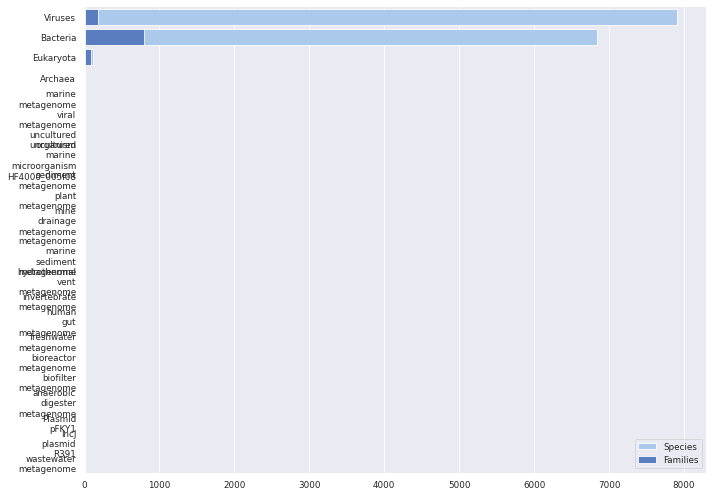

In [52]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 7))

sns.set_theme(context="paper", style="darkgrid")

sns.set_color_codes("pastel")
sns.barplot(x="Species name", y="Species superkingdom", data=overview.sort_values("Species name", ascending=False).reset_index(),
            label="Species", color="b")

sns.set_color_codes("muted")
sns.barplot(x="Species family", y="Species superkingdom", data=overview.sort_values("Species name", ascending=False).reset_index(),
            label="Families", color="b")

ax.legend(ncol=1, loc="lower right", frameon=True)

ax.set(ylabel="", xscale="log", xlabel="")

# ax.set_title("Number of taxonomic species and family \nper pathogen superkingdom", fontdict=title_params)

yticks = ax.get_yticks().tolist()
yticks[7] = "uncultured marine\nmicroorganism HF4000_005I08"
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[7] = "uncultured marine\nmicroorganism HF4000_005I08"
# for label in labels:
#     label = label.replace(" ", "\n")

ax.set_yticklabels(ax.get_yticklabels()) ## mod
    
sns.despine(left=True, bottom=True)

plt.tight_layout()
# plt.savefig("Superkingdom_family_species_bar.png")

<a id="filter"></a>

In [53]:
# Filter to include only viruses
df = df[df['Species superkingdom'] == 'Viruses']

In [54]:
df.sample(5)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Taxonomic lineage (SPECIES),Species name,Species superkingdom,Species family
4357,1168837,,environmental Halophage eHP-35,Uncharacterized protein,environmental Halophage eHP-35,environmental Halophage eHP-35,Viruses,environmental Halophage eHP-35
2071,223342,,Tomato golden mottle virus-[GT94-R2]; Tomato g...,Capsid protein (Coat protein),Tomato golden mottle virus,Tomato golden mottle virus,Viruses,Geminiviridae
14545,2844803,,Gyrovirus Tu789,CA1 (Capsid protein) (Coat protein),Gyrovirus Tu789,Gyrovirus homsa2,Viruses,Anelloviridae
961,47838,,Chino del tomate virus; Chino del tomate virus...,Capsid protein (Coat protein),Chino del tomate virus,Chino del tomate virus,Viruses,Geminiviridae
14344,2843729,,Arthrobacter phage Mufasa8,Portal protein,Arthrobacter phage Mufasa8,Arthrobacter virus Mufasa8,Viruses,Siphoviridae


In [55]:
df.drop(['Taxonomic lineage (SPECIES)'], axis=1, inplace=True)

In [56]:
# Convert empty strings to nan for easy downstream processing
df['Virus hosts'] = np.where(df['Virus hosts']=='', np.nan, df['Virus hosts'])

In [57]:
df[df['Virus hosts'].isnull()].sample(3)

,Species taxonomic ID,Virus hosts,Organism,Protein names,Species name,Species superkingdom,Species family
8986,2024331,NaN,Bacteriophage T5-like pork27,Portal protein,Bacteriophage T5-like pork27,Viruses,Demerecviridae
2561,347962,NaN,Bacillus phage Gamma,"Phage portal protein, HK97 family (Putative po...",Bacillus phage Gamma,Viruses,Siphoviridae
14539,2844677,NaN,Gordonia phage Tanis,Portal protein,Gordonia virus Tanis,Viruses,Siphoviridae


In [58]:
df.drop('Organism', axis=1, inplace=True) # Organism == Species name

## Updating host names from other host data in the dataset

Premise: Same virus has same host irrespective of whether the info has been reviewed or not

In [59]:
# List of viruses which do not have assigned hosts in the data
noHostViruses = (df[df['Virus hosts'].isnull()]['Species name']
                 .unique()
                 .tolist())

In [60]:
# Create independent dataframe of viruses with no assigned host and simltaneously identify the same viruses from the data 
# whcih already have assigned hosts and assign host names based on those. 
df_na_hosts = df[(~df['Virus hosts'].isnull()) & (df['Species name'].isin(noHostViruses))][['Species name', 'Virus hosts']]
df_na_hosts = df_na_hosts.groupby('Species name')['Virus hosts'].apply(list) # Reduces dimention
df_na_hosts = df_na_hosts.reset_index(name='Viral hosts nw')

In [61]:
# Previous operation reurns a list for multiple host
# Converts the lists into regular string entries separated by a ;
df_na_hosts['Viral hosts nw'] = (df_na_hosts['Viral hosts nw']
                                 .swifter.progress_bar(desc='Joining host names list', enable=True)
                                 .apply('; '.join))

In [62]:
# Updates the viruses hosts info in the main dataset
df_naa = (df[df['Virus hosts'].isnull()]
          .merge(df_na_hosts, on='Species name', how='left')
          .drop('Virus hosts', axis=1)
          .rename({'Viral hosts nw':'Virus hosts'}, axis=1))

In [63]:
# Creates independant dataset with viruses which have hosts
df_notna = df[~df['Virus hosts'].isnull()]

In [64]:
# merges the updated virus hosts dataset with the dataset with viruses which have hosts
df = df_naa.append(df_notna)

In [65]:
df.shape # Reduced dimention because of grouping, will later ungroup

(7903, 6)

In [66]:
df.sample(5)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
2221,1891721,Capsid protein VP1; Minor capsid protein,Dobsonia moluccensis polyomavirus 1,Viruses,Polyomaviridae,NaN
1997,1779714,Capsid protein (Coat protein),Lycianthes yellow mosaic virus,Viruses,Geminiviridae,NaN
692,537874,Integrase,Streptococcus phage PH15,Viruses,Siphoviridae,NaN
368,227940,GpQ; GpH; GpFI,Yersinia virus L413C,Viruses,Myoviridae,NaN
3686,2170083,Autoprotease p20 (EC 2.7.7.48) (EC 3.4.21.113)...,Pestivirus D,Viruses,Flaviviridae,NaN


In [67]:
print(df[df['Virus hosts'].isnull()].shape)
df[df['Virus hosts'].isnull()].sample(3)

(7299, 6)


,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
3266,2041510,Portal protein,Streptococcus phage V2,Viruses,Siphoviridae,NaN
2915,1985360,Envelope glycoprotein E1 (EC 2.7.7.48) (EC 3.6...,Pegivirus G,Viruses,Flaviviridae,NaN
5667,2676272,Entry/fusion complex component; IMV membrane p...,Equine molluscum contagiosum-like virus,Viruses,Poxviridae,NaN


In [68]:
df['Virus hosts'] = np.where(df['Virus hosts'].isnull(), '', df['Virus hosts'])

In [69]:
df.sample(3)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
1213,1175848,Major capsid protein L1; Minor capsid protein L2,Gammapapillomavirus 6,Viruses,Papillomaviridae,
1149,1157338,Capsid polyprotein VP90 [Cleaved into: Capsid ...,Canine astrovirus,Viruses,Astroviridae,
155,78395,Capsid protein (Coat protein),Sugarcane streak Reunion virus,Viruses,Geminiviridae,


In [70]:
df = mergeRows(df, 'Species taxonomic ID','Virus hosts') # mergeRows in zoonosis_helper_functions.py

In [71]:
df[(df['Species name'].str.contains('Influenza A virus')) & (df['Virus hosts'] != '')]

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family
157,11320,; Homo sapiens (Human) [TaxID: 9606]; Aves [Ta...,Hemagglutinin HA2 chain]; Hemagglutinin [Cleav...,Influenza A virus,Viruses,Orthomyxoviridae


In [72]:
df.sample(3)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family
593,173443,Salmonella typhimurium [TaxID: 90371],9; DNA transfer protein gp7,Salmonella virus ST64T,Viruses,Podoviridae
6049,2608294,,Head-tail connector protein,Acinetobacter phage vB_AbaP_D2M,Viruses,Autographiviridae
1838,1289597,,Integrase,Streptococcus phage phi5218,Viruses,Siphoviridae


In [73]:
# Separate dataset for easy tracking of updates
dfna = df[df['Virus hosts'] == '']
df = df[~(df['Virus hosts'] == '')]

In [74]:
dfna.shape

(7299, 6)

In [75]:
df.shape

(604, 6)

In [76]:
track_na_size = dict()
track_na_size.update({"Internal Update": dfna.shape[0]})
track_na_size

{'Internal Update': 7299}

In [77]:
track_df_size = dict()
track_df_size.update({"Internal Update": df.shape[0]})
track_df_size

{'Internal Update': 604}

## Updating host names from external sources

In [78]:
# Data from NCBI Virus
df2 = pd.read_csv('../data/sequences.csv')
df2.shape

(2599675, 3)

In [79]:
df2.sample(2)

,Species,Molecule_type,Host
1911326,Human immunodeficiency virus 1,ssRNA-RT,Homo sapiens
1392396,African swine fever virus,dsDNA,Sus scrofa


In [80]:
df2.drop_duplicates(inplace=True)
df2.shape

(10956, 3)

In [81]:
# Get taxonomic IDs from species names
df2['Species ID'], df2['Host ID'] = df2['Species'].progress_apply(getIDfromName), df2['Host'].progress_apply(getIDfromName)

Getting Species name:   0%|          | 0/10956 [00:00<?, ?it/s]

'Bovine associated bovismacovirus 1'
'Human associated porprismacovirus 1'
'Torque teno seal virus 8'
'Bovine associated porprismacovirus 1'
'Sheep associated porprismacovirus 3'
'Sheep associated porprismacovirus 1'
'Sheep associated porprismacovirus 2'
'Bovine associated bovismacovirus 2'
'Bovine associated huchismacovirus 1'
'Bovine associated drosmacovirus 1'
'Bovine associated cosmacovirus 1'
'Bovine associated huchismacovirus 2'
'Torque teno seal virus 5'
'nan'
'nan'
'nan'
'nan'


Getting Species name:   0%|          | 0/10956 [00:00<?, ?it/s]

'Bolomys lasiurus'
'Bolomys lasiurus'
'Equus asinus x caballus'
'Pipistrellus sp. pipistrellus/pygmaeus AO-2021'
'Pipistrellus musciculus'
'Funisciurus bayonii'
'Rattus sp. r3 YH-2020'
'Rattus sp. r3 YH-2020'
'Soricidae sp. YH-2020'
'Rattus sp. r3 YH-2020'
'Rattus sp. r3 YH-2020'
'Acomys selousi'
'Rhinolophus smithersi'
'Alouatta sp.'
'Pipistrellys abramus'
'Sturnira angeli'
'Sturnira angeli'
'Hipposideros curtus'
'Pipistrellus inexspectatus'
'Dobsonia exoleta'
'Mops demonstrator'
'Pipistrellus musciculus'
'Mus sp. TG-2020'
'Murinae gen. sp. TG-2020'
'Vespadelus baverstocki'
'Ozimops sp. DP-2019'
'Scoterepens balstoni'
'Neoromicia capensis'
'Neoromicia capensis'
'Mus sp. CL-2019'
'Mus sp. CL-2019'
'Neoromicia capensis'
'Equus asinus x caballus'
'Equus caballus x asinus'
'Bolomys lasiurus'
'Bolomys lasiurus'
'Bolomys lasiurus'
'Neoromicia capensis'
'Neoromicia capensis'
'Neoromicia capensis'
'Neoromicia capensis'
'Bolomys lasiurus'
'Pipistrellus inexspectatus'
'Chiroptera sp.'
'Chaereph

In [82]:
df2.dropna(inplace=True)
df2['Species ID'], df2['Host ID'] = df2['Species ID'].astype(int), df2['Host ID'].astype(int)
df2.shape

(10866, 5)

In [83]:
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['Host'], x['Host ID']), axis=1)
# Remove Host and Host ID columns as they have been merged and are no longer needed
df2.drop(['Host', 'Host ID'], axis=1, inplace=True)

Getting Species name:   0%|          | 0/10866 [00:00<?, ?it/s]

In [84]:
df2['Species ID'] = df2['Species ID'].progress_apply(getRankID, rank='species')

Getting Species name:   0%|          | 0/10866 [00:00<?, ?it/s]

In [85]:
## Create a copy for later use
dfff = df2.copy()

In [86]:
# Add host names
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [87]:
dfna.shape

(6271, 6)

In [88]:
df.shape

(1632, 6)

In [89]:
track_na_size.update({"NCBI virus Update": dfna.shape[0]})

track_df_size.update({"NCBI virus Update": df.shape[0]})
track_df_size

{'Internal Update': 604, 'NCBI virus Update': 1632}

In [90]:
# Data from virus host database
df2 = pd.read_table('../data/virushostdb.tsv')
df2.head(3)

,virus tax id,virus name,virus lineage,refseq id,KEGG GENOME,KEGG DISEASE,DISEASE,host tax id,host name,host lineage,pmid,evidence,sample type,source organism
0,438782,Abaca bunchy top virus,Viruses; Monodnaviria; Shotokuvirae; Cressdnav...,"NC_010314, NC_010315, NC_010316, NC_010317, NC...",NaN,NaN,NaN,46838.0,Musa sp.,Eukaryota; Viridiplantae; Streptophyta; Strept...,17978886,"Literature, NCBI Virus, RefSeq",NaN,NaN
1,438782,Abaca bunchy top virus,Viruses; Monodnaviria; Shotokuvirae; Cressdnav...,"NC_010314, NC_010315, NC_010316, NC_010317, NC...",NaN,NaN,NaN,214697.0,Musa acuminata AAA Group,Eukaryota; Viridiplantae; Streptophyta; Strept...,17978886,Literature,NaN,NaN
2,1241371,Abalone herpesvirus Victoria/AUS/2009,Viruses; Duplodnaviria; Heunggongvirae; Peplov...,NC_018874,NaN,NaN,NaN,6451.0,Haliotidae,Eukaryota; Opisthokonta; Metazoa; Eumetazoa; B...,NaN,UniProt,NaN,NaN


In [91]:
df2 = df2[['virus tax id', 'virus name', 'host tax id', 'host name']].copy()
df2.drop_duplicates(inplace=True)
print(df2.shape)
df2.head()

(16612, 4)


,virus tax id,virus name,host tax id,host name
0,438782,Abaca bunchy top virus,46838.0,Musa sp.
1,438782,Abaca bunchy top virus,214697.0,Musa acuminata AAA Group
2,1241371,Abalone herpesvirus Victoria/AUS/2009,6451.0,Haliotidae
3,1241371,Abalone herpesvirus Victoria/AUS/2009,36100.0,Haliotis rubra
4,491893,Abalone shriveling syndrome-associated virus,37770.0,Haliotis diversicolor aquatilis


In [92]:
df2[df2['host tax id'].isnull()]

,virus tax id,virus name,host tax id,host name
1236,2662138,Bacteriophage Phobos,NaN,NaN
3750,1131416,Cucurbit mild mosaic virus,NaN,NaN
15925,1888308,Wabat virus,NaN,NaN


In [93]:
df2.dropna(inplace=True)

In [94]:
df2['host tax id'] = df2['host tax id'].astype(int)
df2.head()

,virus tax id,virus name,host tax id,host name
0,438782,Abaca bunchy top virus,46838,Musa sp.
1,438782,Abaca bunchy top virus,214697,Musa acuminata AAA Group
2,1241371,Abalone herpesvirus Victoria/AUS/2009,6451,Haliotidae
3,1241371,Abalone herpesvirus Victoria/AUS/2009,36100,Haliotis rubra
4,491893,Abalone shriveling syndrome-associated virus,37770,Haliotis diversicolor aquatilis


In [95]:
df2['Species ID'] = df2['virus tax id'].progress_apply(getRankID, rank='species')

Getting Species name:   0%|          | 0/16609 [00:00<?, ?it/s]

In [96]:
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['host name'], x['host tax id']), axis=1)
# Remove Host and Host ID columns as they have been merged and are no longer needed
df2.drop(['host name', 'host tax id'], axis=1, inplace=True)
df2.head()

Getting Species name:   0%|          | 0/16609 [00:00<?, ?it/s]

,virus tax id,virus name,Species ID,Host name
0,438782,Abaca bunchy top virus,438782,Musa sp. [TaxID: 46838]
1,438782,Abaca bunchy top virus,438782,Musa acuminata AAA Group [TaxID: 214697]
2,1241371,Abalone herpesvirus Victoria/AUS/2009,1513231,Haliotidae [TaxID: 6451]
3,1241371,Abalone herpesvirus Victoria/AUS/2009,1513231,Haliotis rubra [TaxID: 36100]
4,491893,Abalone shriveling syndrome-associated virus,491893,Haliotis diversicolor aquatilis [TaxID: 37770]


In [97]:
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [98]:
df.shape

(4731, 6)

In [99]:
dfna.shape

(3172, 6)

In [100]:
track_na_size.update({"Virus-Host DB Update": dfna.shape[0]})

track_df_size.update({"Virus-Host DB Update": df.shape[0]})
track_df_size

{'Internal Update': 604,
 'NCBI virus Update': 1632,
 'Virus-Host DB Update': 4731}

In [101]:
# Data from EID2 (Liverpool University)
df2 = pd.read_csv('../data/virus_host_4rm_untitled.csv')
df2.sample(2)

,Host_name,Host_TaxId,Host Group,Virus_name,Virus_TaxId,Micobe_group,Host_common_name,Host_common_name_rev
32970,homo sapiens,9606,primates,influenza b virus (b/guayaquil/fla0959/2008),545109,viruses,Human,Human
51675,anas clypeata,75838,vertebrates,influenza a virus (a/northern shoveler/interio...,643969,viruses,Northern shoveler,Shoveler


In [102]:
df2 = df2[['Host_name', 'Host_TaxId', 'Virus_name', 'Virus_TaxId']].copy()
df2['Species ID'] = df2['Virus_TaxId'].progress_apply(getRankID, rank='species')
df2['Host name'] = df2.progress_apply(lambda x: nameMerger(x['Host_name'], x['Host_TaxId']), axis=1)
df2.drop(['Host_name', 'Host_TaxId'], axis=1, inplace=True)
df2.dropna(inplace=True)
df2.sample(2)

Getting Species name:   0%|          | 0/59859 [00:00<?, ?it/s]

878474 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found
555869 taxid not found


Getting Species name:   0%|          | 0/59859 [00:00<?, ?it/s]

,Virus_name,Virus_TaxId,Species ID,Host name
592,bat adeno-associated virus,740950,1511897.0,scotophilus kuhlii [TaxID: 153297]
8171,influenza a virus (a/equine/athens/02/2003(h3n8)),760529,11320.0,equus caballus [TaxID: 9796]


In [103]:
df_na_hosts = AggregateHosts(df2,'Species ID', 'Host name')
dfna = dfna.merge(df_na_hosts, left_on='Species taxonomic ID', right_on='Species ID', how='left')
dfna = dfna.drop(['Virus hosts', 'Species ID'], axis=1).rename({'Host name':'Virus hosts'}, axis=1)
dfna = UpdateHosts(dfna, df_na_hosts, 'Species taxonomic ID', 'Species ID')
df, dfna = UpdateMain(df, dfna)
df = mergeRows(df, 'Species taxonomic ID', 'Virus hosts')

In [104]:
df.shape

(4737, 6)

In [105]:
dfna.shape

(3166, 6)

In [106]:
dfna.sample(2)

,Species taxonomic ID,Protein names,Species name,Species superkingdom,Species family,Virus hosts
82,291401,Tape measure protein (TMP),Enterobacteria phage CP-1639,Viruses,Siphoviridae,NaN
3169,2846681,Tail sheath; Portal protein (gp20); Protein Gp...,Yersinia virus ZN18,Viruses,Myoviridae,NaN


In [107]:
track_na_size.update({"EID2 Update": dfna.shape[0]})

track_df_size.update({"EID2 Update": df.shape[0]})
track_df_size

{'Internal Update': 604,
 'NCBI virus Update': 1632,
 'Virus-Host DB Update': 4731,
 'EID2 Update': 4737}

In [108]:
track_na_size

{'Internal Update': 7299,
 'NCBI virus Update': 6271,
 'Virus-Host DB Update': 3172,
 'EID2 Update': 3166}

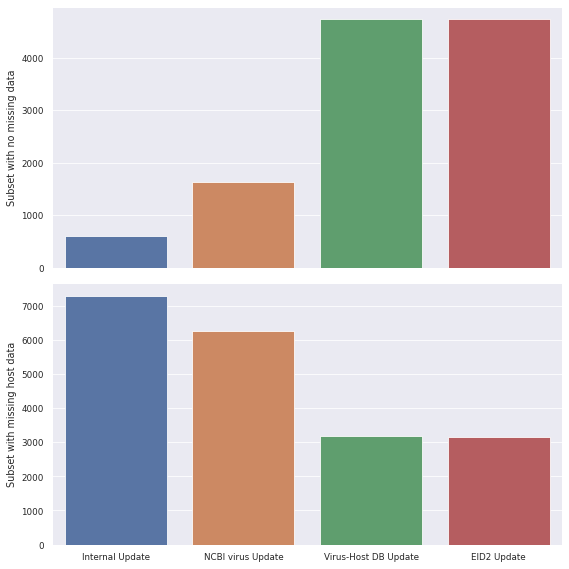

In [109]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# fig.suptitle('Dataset tracking through imputation cycle', fontsize=17, fontweight="bold")

sns.set_theme(context="paper", style="darkgrid")

sns.barplot(data=pd.DataFrame().from_records([track_df_size]), ax=ax[0])

sns.barplot(data=pd.DataFrame().from_records([track_na_size]), ax=ax[1])

ax[0].set_ylabel("Subset with no missing data")
ax[1].set_ylabel("Subset with missing host data")

plt.tight_layout()
# plt.savefig("Tracking.png")

## Further Processing

In [110]:
# Add column to discriminate viruses which contain human hosts from those which do not
df['Infects human'] = np.where(df['Virus hosts'].str.contains(r'960[56]'), 'human-true','human-false')

In [111]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
4092,2734069,Pseudomonas aeruginosa [TaxID: 287],Portal protein,Pseudomonas virus phi3,Viruses,Myoviridae,human-false
833,348058,Salmonella enterica subsp. enterica serovar An...,Tailspike protein,Salmonella phage epsilon34,Viruses,Podoviridae,human-false


In [112]:
df['Virus hosts'] = df['Virus hosts'].str.split('; ')
df['Virus hosts'] = df.progress_apply(lambda x: list(filter(None, x['Virus hosts'])), axis=1) # remove empty items
df['Virus hosts'] = df['Virus hosts'].progress_apply('; '.join)

Getting Species name:   0%|          | 0/4737 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/4737 [00:00<?, ?it/s]

In [113]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
2016,1622024,Desmodus rotundus [TaxID: 9430],Glycoprotein 20 (Glycoprotein 70),Desmodus rotundus endogenous retrovirus,Viruses,Retroviridae,human-false
804,334209,Homo sapiens [TaxID: 9606],Major capsid protein L1; Minor capsid protein L2,Betapapillomavirus 5,Viruses,Papillomaviridae,human-true
321,47000,Camelus dromedarius [TaxID: 9838]; Equus cabal...,Genome polyprotein (EC 3.4.22.28) (P1A) (P1B) ...,Equine rhinitis A virus,Viruses,Picornaviridae,human-false
2824,2015376,Rousettus leschenaultii [TaxID: 9408]; Corynor...,Protein IV; Pre-protein VI (pVI) [Cleaved into...,Bat mastadenovirus G,Viruses,Adenoviridae,human-false


In [114]:
df[df['Infects human'] == 'human-true'].sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
217,12637,Aedes albopictus (Asian tiger mosquito) (Stego...,Non-structural protein 4B (NS4B); Peptide 2k; ...,Dengue virus,Viruses,Flaviviridae,human-true
143,11234,Homo sapiens (Human) [TaxID: 9606],Hemagglutinin glycoprotein; Fusion glycoprotei...,Measles morbillivirus,Viruses,Paramyxoviridae,human-true
1909,1530251,Rattus tanezumi [TaxID: 35732]; Pan troglodyte...,Genome polyprotein (P1C) (P1D) (Virion protein...,Picornaviridae sp.,Viruses,Picornaviridae,human-true
800,334204,Homo sapiens (Human) [TaxID: 9606],Major capsid protein L1; Minor capsid protein L2,Mupapillomavirus 2,Viruses,Papillomaviridae,human-true


<a id="host-name-consistency"></a>

In [115]:
# Ungrouping operation based on host
# 1. Splits Virus host using based on ; separator
# 2. Horizontally stack the data based on virus hosts
df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split(';', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()

In [116]:
df.shape

(7247, 7)

In [117]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human
4630,1981164,Escherichia coli O157:H7 [TaxID: 83334],Phage_fiber_C domain-containing protein; Tail ...,Escherichia virus Stx2 II,Viruses,Podoviridae,human-false
1565,270140,Solanum lycopersicum [TaxID: 4081],Capsid protein (Coat protein),Tomato leaf curl Iran virus,Viruses,Geminiviridae,human-false
6879,2844244,Escherichia [TaxID: 561],Portal vertex protein,Escherichia virus ev015,Viruses,Myoviridae,human-false
3737,1772258,Pavonia [TaxID: 82389],Capsid protein (Coat protein),Pavonia mosaic virus,Viruses,Geminiviridae,human-false


In [118]:
df['Virus hosts ID'] = None
idx_organism = df.columns.get_loc('Virus hosts')
idx_host_id = df.columns.get_loc('Virus hosts ID')

pattern = r'(\d+)\]' # The last digit on some IDs was not captured so include the ] to capture & later remove
for row in range(len(df)):
    host_id = re.search(pattern, df.iat[row, idx_organism]).group()
    df.iat[row, idx_host_id] = host_id
df.head()

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID
0,10243,Mus musculus (Mouse) [TaxID: 10090],CPXV111 protein; CPXV163 protein; CPXV108 prot...,Cowpox virus,Viruses,Poxviridae,human-true,10090]
1,10243,Myodes glareolus (Bank vole) (Clethrionomys g...,CPXV111 protein; CPXV163 protein; CPXV108 prot...,Cowpox virus,Viruses,Poxviridae,human-true,447135]
2,10243,Felis catus (Cat) (Felis silvestris catus) [T...,CPXV111 protein; CPXV163 protein; CPXV108 prot...,Cowpox virus,Viruses,Poxviridae,human-true,9685]
3,10243,Apodemus sylvaticus (European woodmouse) [Tax...,CPXV111 protein; CPXV163 protein; CPXV108 prot...,Cowpox virus,Viruses,Poxviridae,human-true,10129]
4,10243,Bos taurus (Bovine) [TaxID: 9913],CPXV111 protein; CPXV163 protein; CPXV108 prot...,Cowpox virus,Viruses,Poxviridae,human-true,9913]


In [119]:
df['Virus hosts ID'] = df['Virus hosts ID'].str.strip('\]')

In [120]:
df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(int)

df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(getRankID, rank='species')
df['Virus host name'] = df['Virus hosts ID'].progress_apply(getRankName, rank='species')
df['Host superkingdom'] = df['Virus hosts ID'].progress_apply(getRankName, rank='superkingdom')
df['Host kingdom'] = df['Virus hosts ID'].progress_apply(getRankName, rank='kingdom')

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

In [121]:
df[df['Virus hosts ID'].isna()]

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom


In [122]:
df['Virus hosts ID'][1866]

229543

In [123]:
df['Virus hosts ID'] = df['Virus hosts ID'].progress_apply(int)

Getting Species name:   0%|          | 0/7247 [00:00<?, ?it/s]

In [124]:
df['Virus hosts'] = (df.drop('Virus hosts', axis=1)
                     .apply(lambda x: nameMerger(x['Virus host name'], x['Virus hosts ID']), axis=1))

In [125]:
df.sample(4)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
4922,2022412,Grammomys macmillani [TaxID: 248794],Pre-glycoprotein polyprotein GP complex (Pre-G...,Mammarenavirus sp.,Viruses,Arenaviridae,human-false,248794,Grammomys macmillani,Eukaryota,Metazoa
461,11320,Sus scrofa [TaxID: 9823],Hemagglutinin HA2 chain]; Hemagglutinin [Cleav...,Influenza A virus,Viruses,Orthomyxoviridae,human-true,9823,Sus scrofa,Eukaryota,Metazoa
4104,1914020,Vibrio natriegens [TaxID: 691],Tail sheath protein; Tail sheath protein gp18;...,Vibrio virus nt1,Viruses,Myoviridae,human-false,691,Vibrio natriegens,Bacteria,Vibrio natriegens
1811,400121,Larus argentatus [TaxID: 35669],Capsid protein,Gull circovirus,Viruses,Circoviridae,human-false,35669,Larus argentatus,Eukaryota,Metazoa


In [126]:
df.shape

(7247, 11)

In [127]:
# Ungroup based on protein names
df = (df.set_index(df.columns.drop('Protein names',1).tolist())['Protein names']
          .str.split(';', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Protein names'})
          .loc[:, df.columns]
         ).copy()

In [128]:
df.shape

(22528, 11)

In [129]:
df[df["Species name"] == "Vaccinia virus"]["Virus hosts"].unique()

array(['Bos taurus [TaxID: 9913]', 'Oryctolagus cuniculus [TaxID: 9986]',
       'Homo sapiens [TaxID: 9606]', 'Equus caballus [TaxID: 9796]'],
      dtype=object)

In [130]:
df[df['Host superkingdom'].isnull()].shape

(0, 11)

In [131]:
df['Host superkingdom'].unique()

array(['Eukaryota', 'Bacteria', 'Viruses', 'root', 'Archaea'],
      dtype=object)

In [132]:
df[df['Host superkingdom'] == 'Eukaryota'].shape

(18356, 11)

In [133]:
df[df['Host superkingdom'] == 'Viruses'].shape

(4, 11)

In [134]:
df[df['Host superkingdom'] == 'Bacteria'].shape

(4116, 11)

In [135]:
df[df['Host superkingdom'] == 'root'].shape

(38, 11)

In [136]:
df[df['Host superkingdom'] == 'Archaea'].shape

(14, 11)

In [137]:
print(df[df['Host kingdom'] == 'Metazoa'].shape)
df[df['Host kingdom'] == 'Metazoa'].sample(3)

(17292, 11)


,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
14259,1508220,Chaerephon leucogaster [TaxID: 556902],S protein,Bat coronavirus,Viruses,Coronaviridae,human-false,556902,Chaerephon leucogaster,Eukaryota,Metazoa
10517,369960,Sus scrofa [TaxID: 9823],Gag-Pol polyprotein (EC 2.7.7.49) (EC 2.7.7.7...,Porcine type-C oncovirus,Viruses,Retroviridae,human-true,9823,Sus scrofa,Eukaryota,Metazoa
2367,11036,Sigmodon hispidus [TaxID: 42415],Structural polyprotein (p130) [Cleaved into: ...,Venezuelan equine encephalitis virus,Viruses,Togaviridae,human-true,42415,Sigmodon hispidus,Eukaryota,Metazoa


In [138]:
df[df['Infects human'] == 'human-true'].shape

(8442, 11)

In [139]:
df[df['Infects human'] == 'human-false'].shape

(14086, 11)

In [140]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
17583,1977402,Escherichia coli [TaxID: 562],Attachment protein G3P (Gene 3 protein) (Mino...,Escherichia virus M13,Viruses,Inoviridae,human-false,562,Escherichia coli,Bacteria,Escherichia coli
10453,351073,Mammalia [TaxID: 40674],Viral attachment protein sigma 1,Mammalian orthoreovirus,Viruses,Reoviridae,human-false,40674,Mammalia,Eukaryota,Metazoa


In [141]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
20402,2560734,Salmonella enterica [TaxID: 28901],Tail sheath protein,Salmonella virus STP4a,Viruses,Myoviridae,human-false,28901,Salmonella enterica,Bacteria,Salmonella enterica
17823,1981042,Klebsiella pneumoniae [TaxID: 573],Tape measure protein (TMP),Klebsiella virus PKP126,Viruses,Drexlerviridae,human-false,573,Klebsiella pneumoniae,Bacteria,Klebsiella pneumoniae


<a id="issue"></a>

In [142]:
## Virus host name != Virus hosts ### Shared names but not ID eg. Influenza A strain 4 & Influenza A strain 4 == same ID but diff name
for column in df.columns:
    print(column, df[column].nunique())
print('\nDataframe total',len(df))

Species taxonomic ID 4737
Virus hosts 1765
Protein names 2067
Species name 4737
Species superkingdom 1
Species family 85
Infects human 2
Virus hosts ID 1765
Virus host name 1756
Host superkingdom 5
Host kingdom 345

Dataframe total 22528


In [143]:
df.sample(2)

,Species taxonomic ID,Virus hosts,Protein names,Species name,Species superkingdom,Species family,Infects human,Virus hosts ID,Virus host name,Host superkingdom,Host kingdom
836,10245,Homo sapiens [TaxID: 9606],Putative viral membrane protein,Vaccinia virus,Viruses,Poxviridae,human-true,9606,Homo sapiens,Eukaryota,Metazoa
14600,1511906,Neogale vison [TaxID: 452646],Capsid protein 2 (VP2 protein),Carnivore protoparvovirus 1,Viruses,Parvoviridae,human-false,452646,Neogale vison,Eukaryota,Metazoa


## Restructuring the data

In [144]:
# Earlier saved data
dff.sample(2)

,Entry,Species taxonomic ID,Length
179603,Q20M22,11320.0,498
57609,G8EVA4,11320.0,566


In [145]:
dff.shape

(358333, 3)

In [146]:
## Load sequences
# Using custom IO instead of Bio.SeqIO because it was much easier to customise
# Not as efficient but still light on resources

<a id='fasta'></a>

In [147]:
%%time

fastaFileName = '../data/uniprot-keyword Virus+entry+into+host+cell+[KW-1160] +fragment no.fasta'

entry_seq = read_fasta(fastaFileName) # read_fasta in zoonosis_helper_functions.py

CPU times: user 2.81 s, sys: 720 ms, total: 3.53 s
Wall time: 3.63 s


In [148]:
dff.sort_values(by='Entry', inplace=True)

seq_object_list = [seq_obj for entry, seq_obj in entry_seq]

dff['Sequence'] = seq_object_list

In [149]:
dff.head()

,Entry,Species taxonomic ID,Length,Sequence
50368,A0A009FEK4,470.0,392,<zoonosis_helper_functions.FASTASeq object at ...
156673,A0A009G3H3,1310609.0,385,<zoonosis_helper_functions.FASTASeq object at ...
146717,A0A009GC36,470.0,400,<zoonosis_helper_functions.FASTASeq object at ...
146730,A0A009GCG0,470.0,410,<zoonosis_helper_functions.FASTASeq object at ...
144753,A0A009GXT7,1310609.0,399,<zoonosis_helper_functions.FASTASeq object at ...


In [150]:
df.drop(['Virus host name', 'Protein names', 'Species superkingdom'], axis=1, inplace=True)

In [151]:
%%time

df = df.merge(dff, on='Species taxonomic ID', how='left')

df.shape

CPU times: user 10.5 s, sys: 5.37 s, total: 15.8 s
Wall time: 15.8 s


(48729124, 11)

In [152]:
del dff, df2

In [153]:
%%time

df.drop_duplicates(inplace=True)
df.shape

CPU times: user 36.6 s, sys: 11.9 s, total: 48.6 s
Wall time: 48.4 s


(2277906, 11)

In [154]:
df['Virus hosts ID'] = df['Virus hosts ID'].apply(str)

In [155]:
df.head()

,Species taxonomic ID,Virus hosts,Species name,Species family,Infects human,Virus hosts ID,Host superkingdom,Host kingdom,Entry,Length,Sequence
0,10243,Mus musculus [TaxID: 10090],Cowpox virus,Poxviridae,human-true,10090,Eukaryota,Metazoa,A0A0K2YUN2,340.0,<zoonosis_helper_functions.FASTASeq object at ...
1,10243,Mus musculus [TaxID: 10090],Cowpox virus,Poxviridae,human-true,10090,Eukaryota,Metazoa,A0A1B5FLS7,377.0,<zoonosis_helper_functions.FASTASeq object at ...
2,10243,Mus musculus [TaxID: 10090],Cowpox virus,Poxviridae,human-true,10090,Eukaryota,Metazoa,A0A1S5WL42,304.0,<zoonosis_helper_functions.FASTASeq object at ...
3,10243,Mus musculus [TaxID: 10090],Cowpox virus,Poxviridae,human-true,10090,Eukaryota,Metazoa,A0A1V0FXA9,304.0,<zoonosis_helper_functions.FASTASeq object at ...
4,10243,Mus musculus [TaxID: 10090],Cowpox virus,Poxviridae,human-true,10090,Eukaryota,Metazoa,A0A1V0FXG9,377.0,<zoonosis_helper_functions.FASTASeq object at ...


In [156]:
%%time

# Group by Entry and aggregate using set function to avoid duplication
df = (df.groupby('Entry', as_index=False)
       .agg({'Virus hosts':set, #'Protein':set, 
             'Infects human':set, 'Species name':set,
             'Host superkingdom':set,
             'Host kingdom':set,
             'Virus hosts ID':set,
             'Species family':set,
             'Species taxonomic ID':'first',
             'Sequence': 'first', 'Length': 'first',})) 

# joint the set columns into a string separated by a ;
# First column is 'Entry' so skip index 0, last 3 columns need not be joined
df.iloc[:, 1:-3] = df.iloc[:, 1:-3].swifter.applymap('; '.join)

Pandas Apply:   0%|          | 0/2222927 [00:00<?, ?it/s]

CPU times: user 17.5 s, sys: 329 ms, total: 17.8 s
Wall time: 17.7 s


In [157]:
df.shape

(317561, 11)

In [158]:
%%time

# Get additional sequence info from the dataset
df['Sequence'] = df.progress_apply(lambda x: getSequenceFeatures(
    seqObj=x['Sequence'], entry=x['Entry'],
    organism=x['Species name'], status=x['Infects human']), axis=1)

Pandas Apply:   0%|          | 0/317561 [00:00<?, ?it/s]

CPU times: user 5.98 s, sys: 119 ms, total: 6.1 s
Wall time: 5.99 s


<a id="protein-names-from-sequence"></a>

In [159]:
df['Protein'] = df['Sequence'].apply(lambda sequence: sequence.protein_name)

In [160]:
df.sample(3)

,Entry,Virus hosts,Infects human,Species name,Host superkingdom,Host kingdom,Virus hosts ID,Species family,Species taxonomic ID,Sequence,Length,Protein
115731,A0A2P1HS72,Homo sapiens [TaxID: 9606],human-true,Alphapapillomavirus 9,Eukaryota,Metazoa,9606,Papillomaviridae,337041,<zoonosis_helper_functions.FASTASeq object at ...,473.0,Minor capsid protein L2
153564,A0A5B8DKJ4,Homo sapiens [TaxID: 9606]; Sus scrofa [TaxID:...,human-true,Enterovirus B,Eukaryota,Metazoa,9823; 9606,Picornaviridae,138949,<zoonosis_helper_functions.FASTASeq object at ...,2191.0,Genome polyprotein
18434,A0A0B5G7L9,Pan troglodytes [TaxID: 9598]; Gorilla gorilla...,human-true,Hepatitis B virus,Eukaryota,Metazoa,9577; 9593; 9598; 9600; 9606,Hepadnaviridae,10407,<zoonosis_helper_functions.FASTASeq object at ...,183.0,Capsid protein


In [161]:
df[df['Infects human'] == 'human-true'].shape

(278791, 12)

In [162]:
df[df['Infects human'] == 'human-false'].shape

(38770, 12)

In [163]:
# Sequences loaded earlier from NCBI Virus ###Add Molecule type
dfff.rename({'Species ID': 'Species taxonomic ID', 'Molecule_type': 'Molecule type'}, axis=1, inplace=True)
dfff.head()

,Species,Molecule type,Species taxonomic ID,Host name
0,Epsilonarterivirus zamalb,ssRNA(+),2501966,Chlorocebus [TaxID: 392815]
1,Rodent arterivirus,ssRNA(+),1806636,Eothenomys inez [TaxID: 870526]
2,Wencheng Sm shrew coronavirus,ssRNA(+),1508228,Suncus murinus [TaxID: 9378]
3,Bat coronavirus,ssRNA(+),1508220,Eidolon helvum [TaxID: 77214]
4,NL63-related bat coronavirus strain BtKYNL63-9b,ssRNA(+),2501929,Triaenops afer [TaxID: 549403]


In [164]:
df['Species taxonomic ID'] = df['Species taxonomic ID'].apply(int)

In [165]:
%%time

df = df.merge(dfff[['Species taxonomic ID', 'Molecule type']], how='left', on='Species taxonomic ID')

CPU times: user 2.82 s, sys: 1.34 s, total: 4.16 s
Wall time: 4.16 s


In [166]:
df.shape

(8419758, 13)

In [167]:
%%time

df.drop_duplicates(inplace=True)

CPU times: user 9.06 s, sys: 2.33 s, total: 11.4 s
Wall time: 11.4 s


In [168]:
df.shape

(317561, 13)

In [169]:
del dfff

## Reorganise dataframe

In [170]:
df = df[['Entry', 'Protein', 'Length', 'Species name', 
         'Species taxonomic ID', 'Species family', 'Virus hosts',
         'Virus hosts ID', 'Host kingdom', 
         'Host superkingdom', 'Molecule type', 'Infects human', 'Sequence']]

In [171]:
df.sample(2)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence
4624736,A0A7G9XVY7,Spike glycoprotein,1273.0,Severe acute respiratory syndrome-related coro...,694009,Coronaviridae,Rhinolophus macrotis [TaxID: 196889]; Rhinolop...,59479; 196889; 9675; 188571; 89399; 9606,Metazoa,Eukaryota,ssRNA(+),human-true,<zoonosis_helper_functions.FASTASeq object at ...
5646987,D5XIF8,Hemagglutinin,566.0,Influenza A virus,11320,Orthomyxoviridae,Sturnira lilium [TaxID: 27660]; Sus scrofa [Ta...,9691; 9796; 9709; 8782; 9761; 9721; 9685; 2766...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...


## Split Dataframe to multiple datasets

In [172]:
df['Host superkingdom'].unique()

array(['Eukaryota', 'Bacteria', 'root', 'Archaea', 'Viruses',
       'Eukaryota; root'], dtype=object)

In [173]:
df['Host kingdom'].unique()

array(['Metazoa', 'Viridiplantae', 'Lactococcus lactis',
       'Escherichia coli', 'Serratia marcescens',
       'Mycolicibacterium smegmatis', 'Bacillus thuringiensis',
       'Trichormus variabilis', 'Listeria monocytogenes',
       'Pseudomonas syringae', 'Viridiplantae; Metazoa',
       'Cronobacter sakazakii', 'Staphylococcus epidermidis',
       'Enterococcus faecium', 'root', 'Caulobacter vibrioides',
       'Vibrio alginolyticus', 'Staphylococcus aureus', 'Bacillus cereus',
       'Ralstonia solanacearum', 'Klebsiella pneumoniae',
       'Staphylococcus xylosus; Staphylococcus aureus',
       'Acinetobacter baumannii', 'Dickeya sp.',
       'Lactobacillus delbrueckii', 'Salmonella', 'Bacillus pumilus',
       'Citrobacter; Citrobacter freundii', 'Mycobacterium',
       'Rhizobium leguminosarum', 'Mesorhizobium loti',
       'Shigella flexneri', 'Yersinia enterocolitica',
       'Idiomarinaceae bacterium N2-2', 'Sulfitobacter sp. CB2047',
       'Lelliottia sp. GL2', 'Clostridi

In [174]:
df[(df['Host kingdom'].str.contains('Viridiplantae')) | df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens')].shape

(284539, 13)

In [175]:
title_params

{'fontsize': 17, 'fontweight': 'bold'}

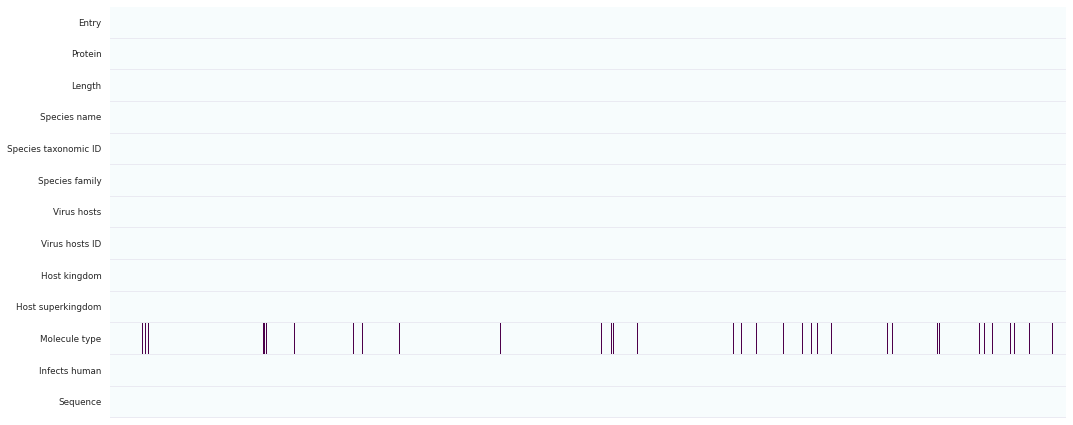

In [176]:
sns.set_theme(context="paper", style="darkgrid")
plt.figure(figsize=(15,6))

ax = sns.heatmap(df.copy().T.isnull(), cmap="BuPu", cbar=False, xticklabels=False)

# ax.set_title("Missing values in the dataset after processing", fontdict=title_params)

plt.tight_layout()
# plt.savefig("Processed_heatmap.png")

In [177]:
df['Molecule type'] = np.where(df['Molecule type'].isna(), '', df['Molecule type'])

In [178]:
df[df['Molecule type'].isna()]

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence


In [179]:
df[df['Host kingdom'].str.contains('Metazoa')][df[df['Host kingdom'].str.contains('Metazoa')]['Molecule type']
                                               .str.contains('DNA')].shape

(31523, 13)

In [180]:
df[df['Host kingdom'].str.contains('Metazoa')][df[df['Host kingdom'].str.contains('Metazoa')]['Molecule type']
                                               .str.contains('RNA')].shape

(273090, 13)

In [181]:
df.shape

(317561, 13)

In [182]:
df[~df['Host kingdom'].str.contains('Metazoa')].shape

(10233, 13)

In [183]:
df[(df['Host superkingdom'].isin(['Bacteria', 'Viruses', 'Archaea'])) |
   (df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens'))].shape

(283447, 13)

In [184]:
unfiltered = df.copy()

metazoa = df[df['Host kingdom'].str.contains('Metazoa')].copy()

plant_human = df[(df['Host kingdom'].str.contains('Viridiplantae')) |
                 df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens')].copy()

NonEukaryote_Human = df[(df['Host superkingdom'].isin(['Bacteria', 'Viruses', 'Archaea'])) |
                        (df['Virus hosts'].str.contains('[Hh]omo [Ss]apiens'))].copy()

DNA_MetazoaZoonosis = metazoa[metazoa['Molecule type'].str.contains('DNA')].copy()

RNA_MetazoaZoonosis = metazoa[metazoa['Molecule type'].str.contains('RNA')].copy()

In [185]:
df.groupby("Infects human").agg(lambda x: len(set(x)))

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Sequence
Infects human,,,,,,,,,,,,
human-false,38770,871,1650.0,4390,4390,77,1405,1407,375,6,12,38770
human-true,278791,319,1278.0,346,346,33,143,143,2,1,12,278791


In [186]:
def check_dist(df):
    true_count = df[df['Infects human'].str.contains('true')].shape[0]
    false_count = df[df['Infects human'].str.contains('false')].shape[0]
    imb = (false_count/true_count)
    print('The minoity class is %.2f of the majority\nhuman-true == %d and human false == %d\n' % (imb, true_count, false_count))

In [187]:
dataframes = [metazoa, unfiltered, plant_human, NonEukaryote_Human, DNA_MetazoaZoonosis, RNA_MetazoaZoonosis]
for dt in dataframes:
    check_dist(dt)

The minoity class is 0.10 of the majority
human-true == 278757 and human false == 28571

The minoity class is 0.14 of the majority
human-true == 278791 and human false == 38770

The minoity class is 0.02 of the majority
human-true == 278791 and human false == 5748

The minoity class is 0.02 of the majority
human-true == 278757 and human false == 4690

The minoity class is 0.29 of the majority
human-true == 24518 and human false == 7005

The minoity class is 0.07 of the majority
human-true == 254070 and human false == 19020



In [188]:
# df.head()

In [189]:
# pd.melt(df.sample(100), value_vars="Infects human")

In [190]:
df["Molecule type"].unique()

array(['ssRNA(+)', 'ssRNA(-)', 'dsDNA', 'ssRNA-RT', '', 'ssRNA(+/-)',
       'ssDNA(+/-)', 'dsRNA', 'dsDNA-RT', 'ssDNA(-)', 'unknown', 'ssDNA',
       'RNA'], dtype=object)

## Random Undersampling of datasets

In [191]:
seed = 960505

In [192]:
# Undersample majority class such that minority class (human-false) is 60% of the majority class (human-true317316)
rus = RandomUnderSampler(sampling_strategy=0.6, random_state=seed)
sampled_dataframes = []
for dt in dataframes:
    clas = dt['Infects human']
#     print('Dataframe before sampling: ', dt.shape[0])
    dt, _ = rus.fit_resample(dt, clas)
    sampled_dataframes.append(dt)
    check_dist(dt)
#     print('Dataframe after sampling: ', dt.shape[0])

The minoity class is 0.60 of the majority
human-true == 47618 and human false == 28571

The minoity class is 0.60 of the majority
human-true == 64616 and human false == 38770

The minoity class is 0.60 of the majority
human-true == 9580 and human false == 5748

The minoity class is 0.60 of the majority
human-true == 7816 and human false == 4690

The minoity class is 0.60 of the majority
human-true == 11675 and human false == 7005

The minoity class is 0.60 of the majority
human-true == 31700 and human false == 19020



In [193]:
metazoaFile = 'MetazoaZoonosis'
plant_humanFile = 'Plant-HumanZoonosis'
unfilteredFile = 'Zoonosis'
NonEukaryote_HumanFile = 'NonEukaryote-Human'
DNA_metazoaFile = 'DNA-MetazoaZoonosis'
RNA_metazoaFile = 'RNA-MetazoaZoonosis'

## Same order as dataframes
files = [metazoaFile, unfilteredFile, plant_humanFile,
         NonEukaryote_HumanFile, DNA_metazoaFile, RNA_metazoaFile]

In [194]:
def plot_strips(df, title, save):
    proteins = "Protein"
    hosts = "Virus hosts"
    status = "Infects human"
    vals = [proteins, hosts, status]
    df = df.copy()
    
    df = (df.set_index(df.columns.drop('Virus hosts', 1).tolist())['Virus hosts'].str.split('; ', expand=True)
          .stack()
          .reset_index()
          .rename(columns={0:'Virus hosts'})
          .loc[:, df.columns]
         ).copy()
    
    
    true_overview = pd.pivot_table(df[df["Infects human"] == "human-true"], values=vals,
                                   index="Species name",
                                   aggfunc={
                                       proteins: lambda x: len(set(x)),
                                       hosts: lambda x: len(set(x))
                                   }
                                  )

    false_overview = pd.pivot_table(df[df["Infects human"] == "human-false"], values=vals,
                                    index="Species name",
                                    aggfunc={
                                        proteins: lambda x: len(set(x)),
                                        hosts: lambda x: len(set(x))
                                    }
                                   )
    
    # return true_overview.sample(5)
    fig, ax = plt.subplots(nrows=2, ncols=2, sharey='row', sharex='col', figsize=(8,8))
    sns.set_theme(context="paper", style="darkgrid")

    # fig.suptitle(title, fontsize=17, fontweight="bold")
    
    sns.set_palette("Dark2")
    np.random.seed(seed=222)
    sns.stripplot(y=true_overview[proteins], ax=ax[0, 0])
    np.random.seed(seed=222)
    sns.stripplot(y=false_overview[proteins], ax=ax[1, 0])
    
    sns.set_palette("tab20b")
    np.random.seed(seed=222)
    sns.stripplot(y=true_overview[hosts], ax=ax[0, 1])
    np.random.seed(seed=222)
    sns.stripplot(y=false_overview[hosts], ax=ax[1, 1])

    ax[1, 0].set_xlabel('Virus proteins',)
    ax[1, 1].set_xlabel('Virus hosts')

    ax[0, 1].set_ylabel('')
    ax[1, 1].set_ylabel('')
    
    ax[0, 0].set_ylabel('Human True')
    ax[1, 0].set_ylabel('Human False')

    fig.tight_layout()
    # plt.savefig(save)

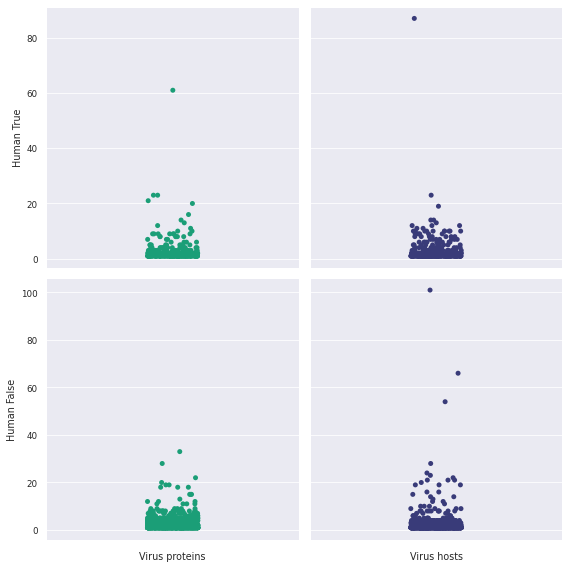

In [195]:
plot_strips(df=metazoa, title='MetazoaZoonosis', save="MetazoaZoonosis_Protein_host_stripplot.png")

CPU times: user 56.4 s, sys: 9.09 s, total: 1min 5s
Wall time: 1min 4s


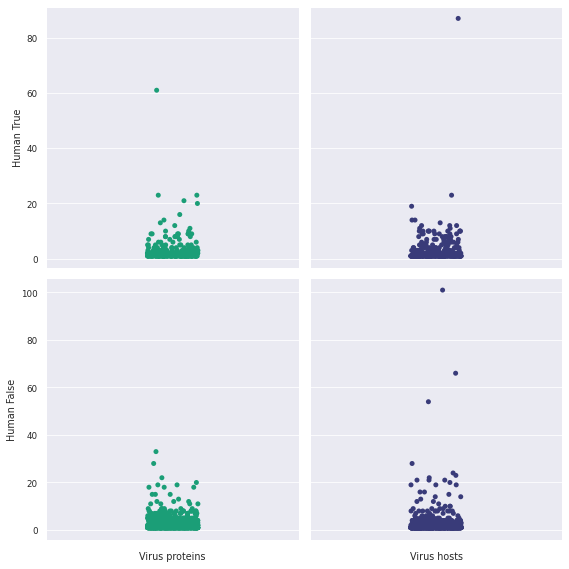

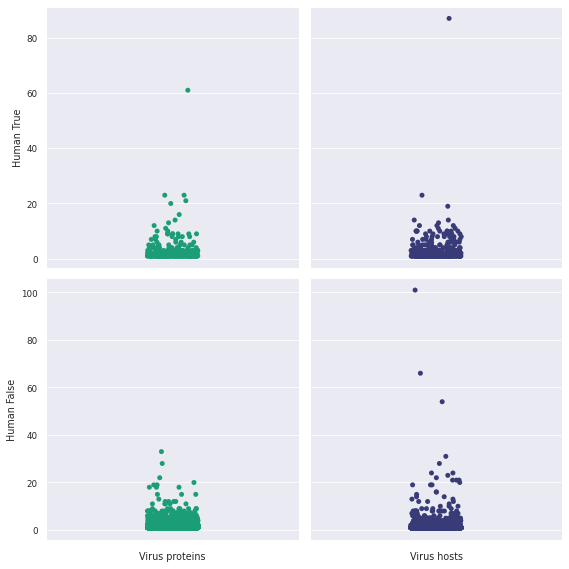

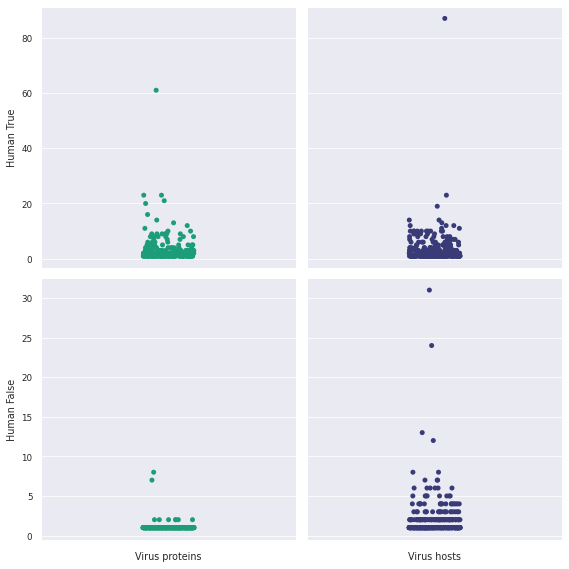

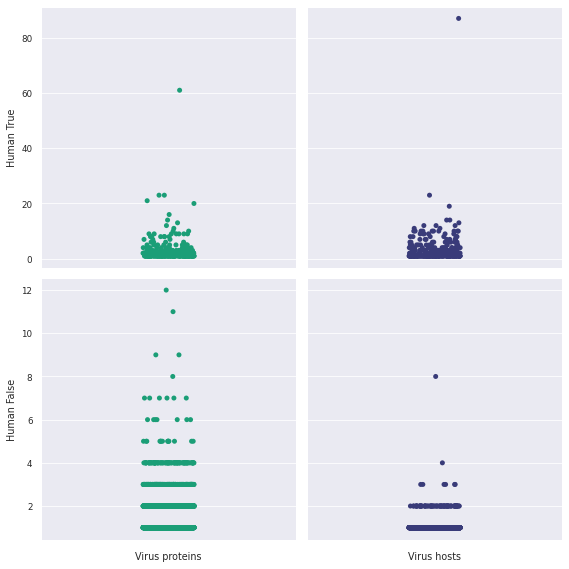

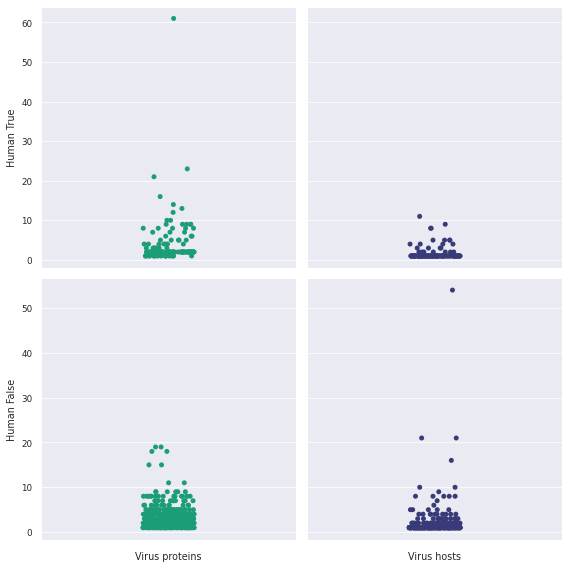

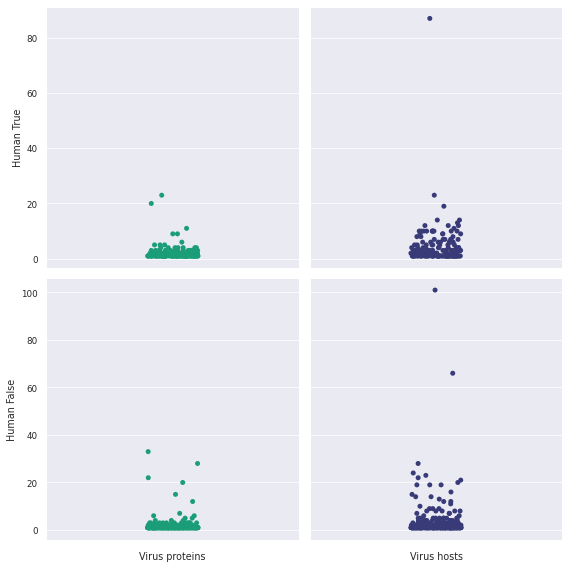

In [196]:
%%time
# plot_swams(NonEukaryote_Human, plot_title)
for df, name in zip(dataframes, files):
    title_plot = f"The distribution of the number of virus hosts and proteins\nby infection status in the {name} subset"
    
    plot_strips(df, title_plot, save=f"{name}_Protein_host_stripplot.png")

In [197]:
full_set = pd.DataFrame()

for df, name in zip(dataframes, files):
    df["Subset"] = name
    full_set = full_set.append(df)

full_set.sample(3)

,Entry,Protein,Length,Species name,Species taxonomic ID,Species family,Virus hosts,Virus hosts ID,Host kingdom,Host superkingdom,Molecule type,Infects human,Sequence,Subset
6434496,G9M4F5,Hemagglutinin,566.0,Influenza A virus,11320,Orthomyxoviridae,Sturnira lilium [TaxID: 27660]; Sus scrofa [Ta...,9691; 9796; 9709; 8782; 9761; 9721; 9685; 2766...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...,Zoonosis
870954,A0A0H3V505,Envelope glycoprotein gp160,886.0,Simian immunodeficiency virus,11723,Retroviridae,Pan troglodytes [TaxID: 9598]; Cercopithecidae...,9596; 9598; 9527,Metazoa,Eukaryota,ssRNA-RT,human-false,<zoonosis_helper_functions.FASTASeq object at ...,Zoonosis
4659447,A0A7H1RHL8,Hemagglutinin,566.0,Influenza A virus,11320,Orthomyxoviridae,Sturnira lilium [TaxID: 27660]; Sus scrofa [Ta...,9691; 9796; 9709; 8782; 9761; 9721; 9685; 2766...,Metazoa,Eukaryota,ssRNA(-),human-true,<zoonosis_helper_functions.FASTASeq object at ...,RNA-MetazoaZoonosis


In [213]:
np.log(df["Length"])

0          8.128880
15         8.128880
30         8.128880
45         7.802209
58         6.327937
             ...   
8419707    6.194405
8419722    6.190315
8419737    6.388561
8419742    6.388561
8419748    6.388561
Name: Length, Length: 273090, dtype: float64

In [219]:
tmp = dataframes[2].copy()
tmp["Length"] = np.log(tmp["Length"])

In [233]:
10**4

10000

In [277]:
def length_stripplots(df, file):
    fig, ax = plt.subplots(figsize=(8, 5))

    sns.set_theme("paper", "darkgrid", "Set1")



    np.random.seed(seed=222)
    ax = sns.stripplot(data=df,
                       x="Infects human", 
                       y="Length",)

    ax.set_yscale("log")
    ax.set_xlabel("")
    ax.set_xticklabels(["Human true", "Human false"])
    ax.set_ylabel("Log(Protein length)")
    plt.tight_layout()
    plt.savefig(f"length_strip_{file}.png")

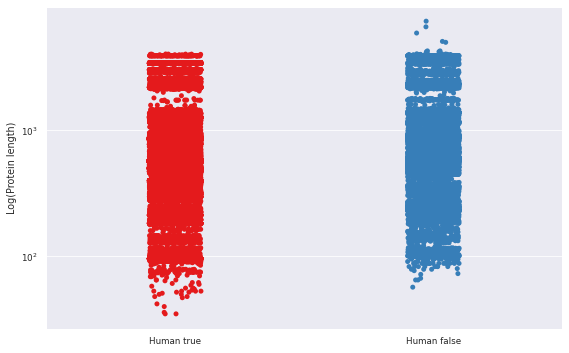

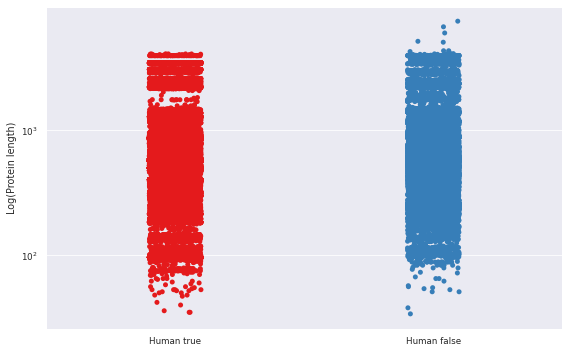

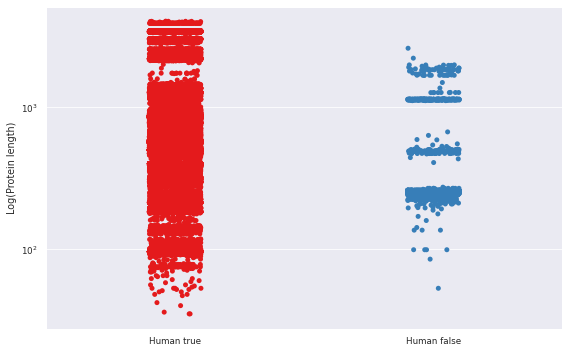

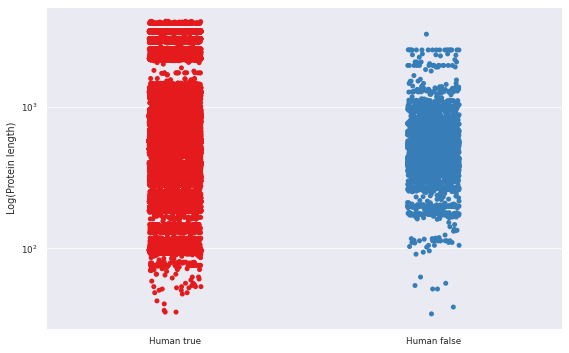

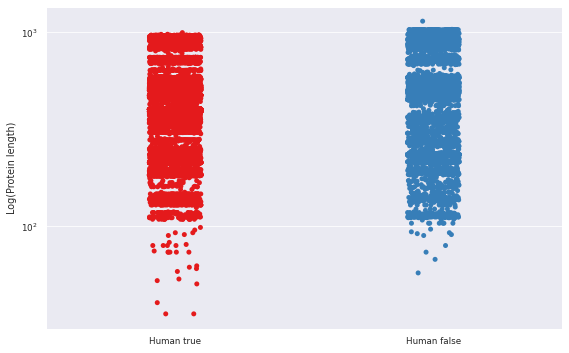

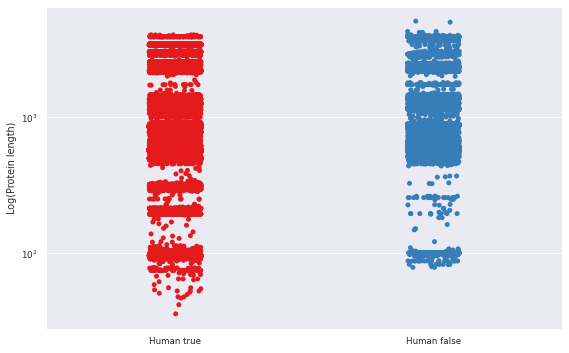

In [278]:
for df, name in zip(dataframes, files):
    length_stripplots(df, name)

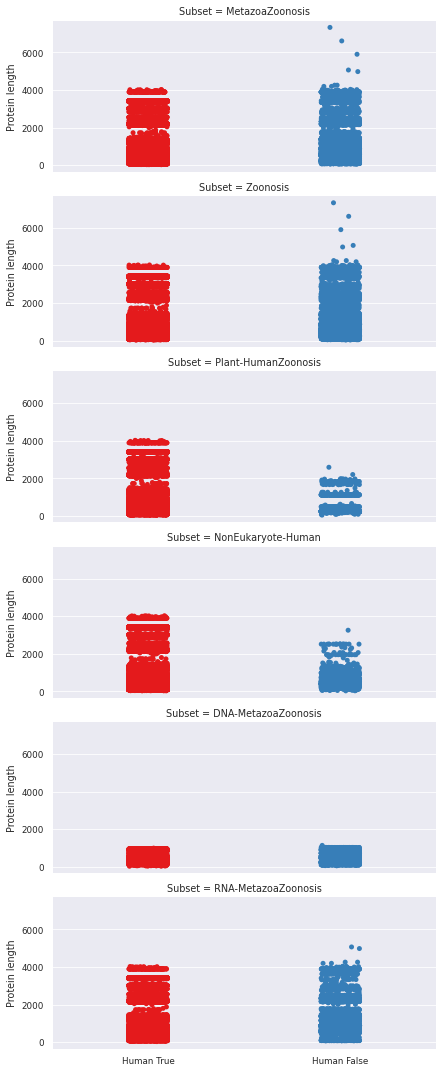

In [198]:
# sns.set_theme("paper", "darkgrid", "Set1")

# g = sns.catplot(data=full_set,
#                 x="Infects human", 
#                 y="Length",
#                 row="Subset",
#                 kind="strip",
#                 aspect=5/2,
#                 size=2.5
#     )

# # g.fig.suptitle("Distributions of protein sequence lengths (bp)\nby virus infection status per subset",
# #                y=1.0,
# #                fontsize=17, fontweight="bold")

# # g.fig.set_ylabel("Protein length")

# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(["Human True", "Human False"])
#     _ = axes.set_xlabel("")
#     _ = axes.set_ylabel("Protein length")
        


# plt.tight_layout()
# # g.fig.savefig("Subset_length_status.png")

In [273]:
# order = sorted(filter(None, metazoa["Molecule type"].unique().tolist()))
order = ['ssRNA(+)', 'ssRNA(-)', 'ssRNA(+/-)',
         'ssRNA-RT', 'dsRNA', 'RNA', 'ssDNA',
         'ssDNA(-)', 'ssDNA(+/-)', 'dsDNA-RT',
         'dsDNA-RT', 'dsDNA', 'unknown']

In [275]:
def molecule_count_bar(df, file):
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.set_theme("paper", "darkgrid", "Set1")

    ax = sns.countplot(data=df,
                       x="Molecule type",
                       hue="Infects human", 
                       order=order,
                      )
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_yscale("log")
    plt.tight_layout()
    plt.savefig(f"molecue_bar_{file}.png")

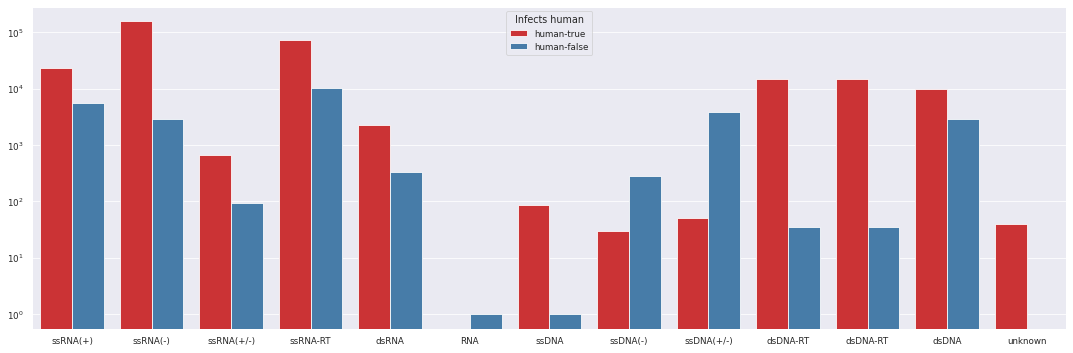

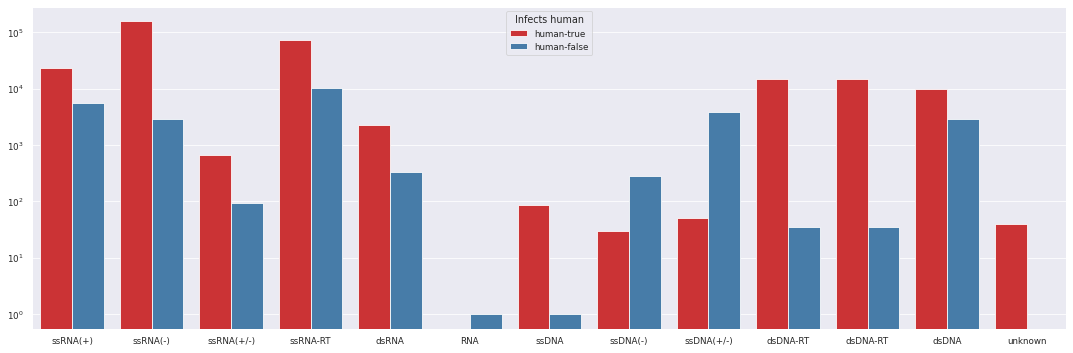

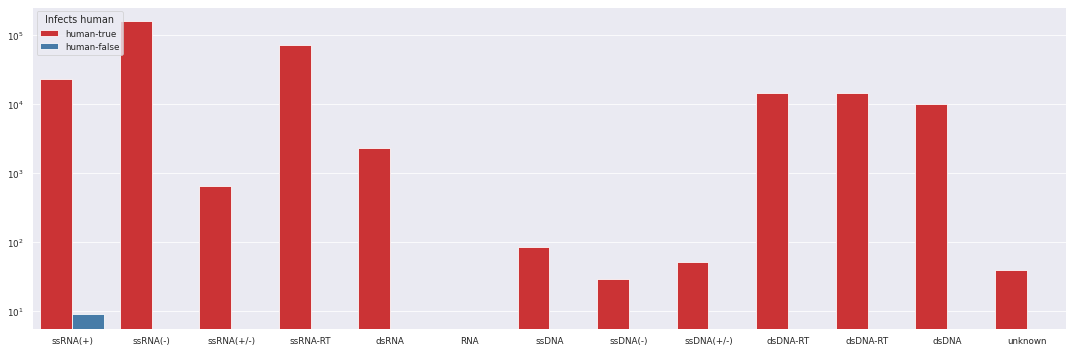

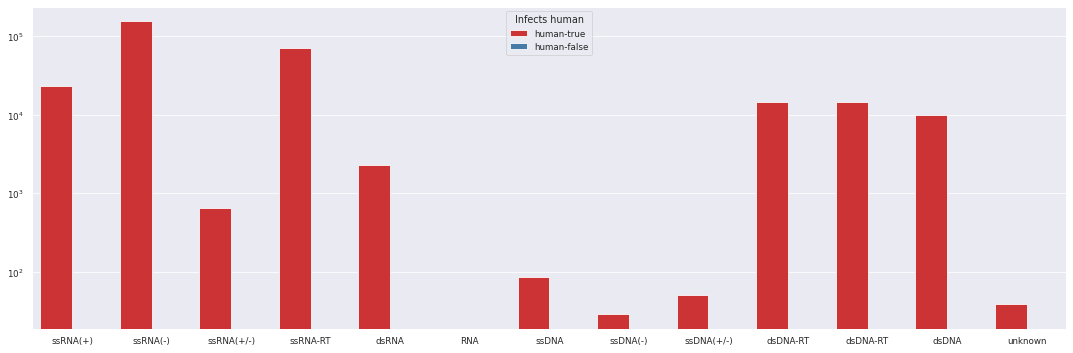

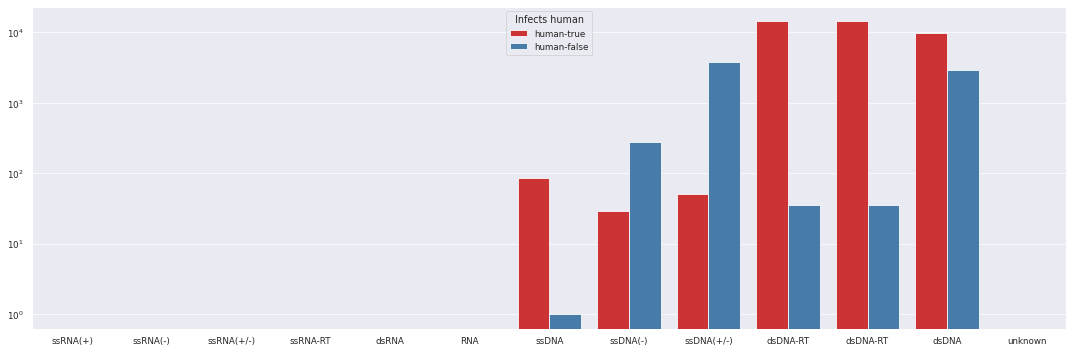

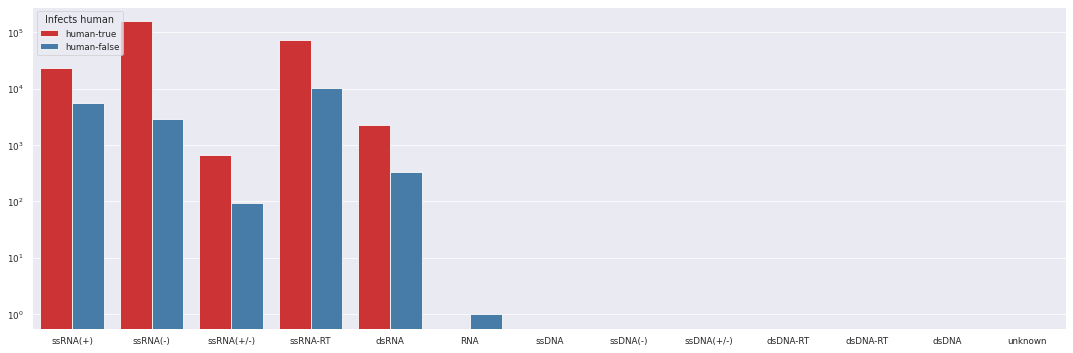

In [276]:
for df, name in zip(dataframes, files):
    molecule_count_bar(df, name)

In [279]:
# # plt.figure(figsize=(15,8))
# sns.set_theme("paper", "darkgrid", "Set1")

# g = sns.catplot(data=full_set,
#                 row="Subset",
#                 x="Molecule type",
#                 hue="Infects human",
#                 kind="count",
#                 order=order,
#                 palette="Set1",
#                 aspect=1.5,
#     )

# # g.fig.suptitle("Ditribustion of viruses by nucleic acid molecule type per subset", fontsize=17, fontweight="bold", y=1.0)

# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
#     _ = axes.set_ylabel("")
#     _ = axes.set_xlabel("")

# sns.move_legend(g, "upper right", bbox_to_anchor=(0.98, 0.975))
# plt.tight_layout()
# # g.fig.savefig("Distribustion_of_virus_nuclear_molecule_types.png")

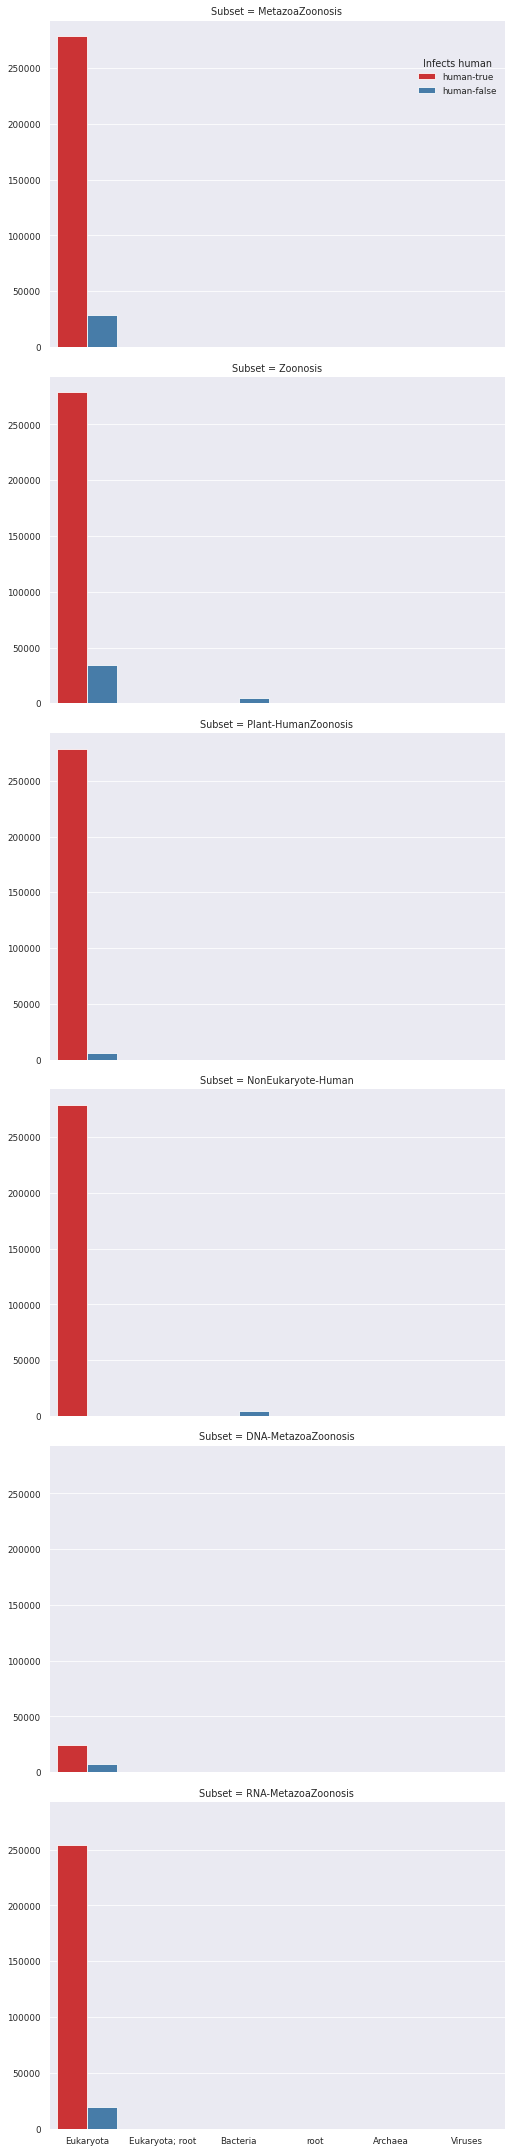

In [201]:
sns.set_theme("paper", "darkgrid", "Set1")

g = sns.catplot(data=full_set,
            row="Subset",
            hue="Infects human", x="Host superkingdom",
            kind="count", palette="Set1", aspect=1.2)

# g.fig.suptitle("Host variation per subset", fontsize=17, fontweight="bold", y=1.0)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels())
    _ = axes.set_ylabel("")
    _ = axes.set_xlabel("")
    

sns.move_legend(g, "upper right", bbox_to_anchor=(0.98, 0.975))
plt.tight_layout()
# g.fig.savefig("Distribustion_of_virus_nuclear_molecule_types.png")

## Write file sequences to fasta for feature extraction

In [202]:
## Same order as dataframes
files = [metazoaFile, unfilteredFile, plant_humanFile,
         NonEukaryote_HumanFile, DNA_metazoaFile, RNA_metazoaFile]

dirs = [os.path.join('../data/', fol) for fol in files] # Do not include in script

toSave = list(zip(sampled_dataframes, files, dirs))

<a id="splits"></a>

In [203]:
# for dff, file, folder in toSave:
#     # Create subdirectories
#     # os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
#     # os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
#     os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
#     os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

#     # save dataframes as csv
#     dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')
    
#     # Split data to train and test data
#     train, test = train_test_split(dff, test_size=0.2, random_state=2022) # Will further split 15% of train as validation during training
#     # Save test and train sequences
#     save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
#     save_sequences(test, f'{folder}/test/Sequences')
    
#     print('Done with', file)

In [204]:
# Undersample majority class such that minority class (human-false) is 60% of the majority class (human-true317316)
rus = RandomUnderSampler(sampling_strategy=2/3, random_state=seed)
sampled_dataframes = []
for dt in dataframes:
    clas = dt['Infects human']
#     print('Dataframe before sampling: ', dt.shape[0])
    dt, _ = rus.fit_resample(dt, clas)
    sampled_dataframes.append(dt)
    check_dist(dt)
#     print('Dataframe after sampling: ', dt.shape[0])

The minoity class is 0.67 of the majority
human-true == 42856 and human false == 28571

The minoity class is 0.67 of the majority
human-true == 58155 and human false == 38770

The minoity class is 0.67 of the majority
human-true == 8622 and human false == 5748

The minoity class is 0.67 of the majority
human-true == 7035 and human false == 4690

The minoity class is 0.67 of the majority
human-true == 10507 and human false == 7005

The minoity class is 0.67 of the majority
human-true == 28530 and human false == 19020



In [284]:
%%time

folder = "/scratch2/users/rserage/ZoonosisFull"
dff = unfiltered
file = 'ZoonosisFull'
# Create subdirectories
# os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
# os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=222) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')

CPU times: user 9.82 s, sys: 521 ms, total: 10.3 s
Wall time: 15.8 s


In [285]:
%%time

rus = RandomUnderSampler(sampling_strategy=1, random_state=seed)
clas = unfiltered['Infects human']
dt, _ = rus.fit_resample(unfiltered, clas)

folder = "/scratch2/users/rserage/ZoonosisOne2One"
dff = dt
file = 'ZoonosisOne2One'
# Create subdirectories
# os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
# os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=222) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')

CPU times: user 3.43 s, sys: 202 ms, total: 3.63 s
Wall time: 3.72 s


In [286]:
%%time

rus = RandomUnderSampler(sampling_strategy=2/3, random_state=seed)
clas = unfiltered['Infects human']
dt, _ = rus.fit_resample(unfiltered, clas)

folder = "/scratch2/users/rserage/ZoonosisTwoThirds"
dff = dt
file = 'ZoonosisTwoThirds'
# Create subdirectories
# os.makedirs(os.path.join(folder, 'train/human-true'), exist_ok=True)
# os.makedirs(os.path.join(folder, 'test/human-true'), exist_ok=True)
os.makedirs(os.path.join(folder, 'train/'), exist_ok=True)
os.makedirs(os.path.join(folder, 'test/'), exist_ok=True)

# save dataframes as csv
dff.drop('Sequence', axis=1).to_csv(f'{folder}/{file}Data.csv.gz', index=False, compression='gzip')

# Split data to train and test data
train, test = train_test_split(dff, test_size=0.2, random_state=222) # Will further split 15% of train as validation during training
# Save test and train sequences
save_sequences(train, f'{folder}/train/Sequences') # Will move to subdirectories after feature extraction
save_sequences(test, f'{folder}/test/Sequences')


CPU times: user 4.12 s, sys: 189 ms, total: 4.31 s
Wall time: 4.44 s
